# To do (NOTES FROM DERBY CLIMATE COALITION):
- Look into correlation between air quality and coronavirus deaths (apparently a correlation between the two)
- Derby.gov.uk should have information on the 72 other Derby sensors, although John pointed out that these are diffusion tubes and are thus only reliable for long-term averages
- NOx and Asmtha are linked - would be interesting to look into if there is data on asmthma admissions/ inhaler prescriptions
- Is there a way to get *national* data - a different website? 
- Check out Luftdaten!

### Look into adding a line showing "safe" level of air pollution on each graph
- [This DEFRA document](https://uk-air.defra.gov.uk/assets/documents/Air_Quality_Objectives_Update.pdf) states the UK Air Quality Objectives
- NO2 target: **200 ug/m3 not to be exceeded more than 18 times in a year**
- NO2 target 2: **40 ug/m3 as annual mean**
- Nitric Oxides target: **30 ug/m3 as annual mean** 

In [1]:
### Imports ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-poster')
from matplotlib.pyplot import *
from datetime import timedelta
import calendar # for getting month name i.e. Feb from month number
from urllib.request import urlretrieve # for getting data from URLs
from datetime import datetime
import datetime as dt
import os # for deleting files
import statsmodels
import statsmodels.api as sm # for time series decomposition
from statsmodels.tsa.filters.hp_filter import hpfilter # for Hodrick-Prescott filter
%matplotlib inline

In [2]:
# get apple mobility data 
# can't get the direct link to the .csv annoyingly so have to download the file and save to my directory
df_apple = pd.read_csv('applemobilitytrends-2020-04-15.csv')

In [3]:
### Get data ###
def get_data(location_input):
    '''Returns data for desired location.
    
    Keyword arguments:
    location -- string of location wanted.
    '''
    # Dictionary of URLs from different locations
    Derby = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2017.csv'
    }
    Reading = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2017.csv'
    }
    Nottingham_Centre = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2017.csv'
    }
    Burton_On_Trent_Centre = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2018.csv'  
    } # no 2017 data for Burton
    
    # Turning above dictionaries into one dictionary
    data_locations = {
      "Derby" : Derby,
      "Reading" : Reading,
      "Nottingham_Centre" : Nottingham_Centre,
      "Burton_Centre" : Burton_On_Trent_Centre
    }

    global df_2020, df_2019, df_2018, df_2017,location_string # so that these can be used outside of function
    location_string = location_input # for plot titles
    
    # Getting URLs for requested location
    URL_2020 = data_locations[location_input]['2020']
    URL_2019 = data_locations[location_input]['2019']
    URL_2018 = data_locations[location_input]['2018']
    URL_2017 = data_locations[location_input]['2017']
   
    # Making dataframes
    df_2020 = pd.read_csv(URL_2020,skiprows=4)
    df_2019 = pd.read_csv(URL_2019,skiprows=4)
    df_2018 = pd.read_csv(URL_2018,skiprows=4)
    df_2017 = pd.read_csv(URL_2017,skiprows=4)
    
    print('Successfully got data for {}!'.format(location_input))

In [4]:
get_data('Derby')

Successfully got data for Derby!


In [5]:
df_2020.tail(2)

Date   time  Nitric oxide status   unit  Nitrogen dioxide  \
2686  21-04-2020  23:00       0.74838      P  ugm-3           7.84125   
2687  21-04-2020  24:00       0.62365      P  ugm-3           7.84125   

     status.1 unit.1  Nitrogen oxides as nitrogen dioxide status.2 unit.2  
2686        P  ugm-3                              8.98875        P  ugm-3  
2687        P  ugm-3                              8.79750        P  ugm-3

## Calculate the date of the last Sunday

In [84]:
dayofweek = datetime.today().weekday()
last_sunday = datetime.today().date()-timedelta(days=dayofweek+1)
last_sunday

datetime.date(2020, 4, 19)

In [6]:
### Cleaning data ###
def datetime_cleaner(variable):
    '''Take every date + time where date is i.e. 1/1/2020 24:00 and turn it into 2/1/2020 00:00. 
    Also removes redundant columns
    
    Keyword arguments:
    variable -- the dataframe inputted i.e. df_2020
    '''
    # Changing date from object to datetime
    variable['Date'] = pd.to_datetime(variable['Date']).dt.strftime('%d-%m-%Y') # makes sure string is in correct format
    variable['Date'] = pd.to_datetime(variable['Date']) # converts to datetime
    
    # Loop to add 1 for every 24th entry, as they are stored as date x & 24:00 when they need to be date x + 1 & 00:00
    counter = 0
    for i, row in variable.iterrows():
        counter += 1
        if counter % 24 == 0:
            value = variable.at[i,'Date'] + pd.Timedelta(1,unit='d')
            variable.at[i,'Date'] = value
    
    # Replacing 24:00 with 00:00
    variable['time'] = variable['time'].replace(to_replace='24:00',value='00:00') 
    
    # Combining date and time columns
    variable['Date String'] = variable['Date'].astype(str)
    variable['Date Time String'] = variable['Date String'] + " " + variable['time']
    variable['Date Time'] = pd.to_datetime(variable['Date Time String'])
    
    # Feature Engineering
    variable['Week'] = variable['Date Time'].dt.week
    variable['Day Of Week'] = variable['Date Time'].dt.dayofweek
    variable['Quarter'] = variable['Date Time'].dt.quarter
    variable['Month'] = variable['Date Time'].dt.month
    variable['Weekday Or Weekend'] = np.where(variable['Day Of Week'] >=5,'Weekend','Weekday')
    variable['Total'] = variable['Nitric oxide'] + variable['Nitrogen dioxide']
    
    # Setting index to be Date Time
    variable.index = variable['Date Time']
    
    # Removing columns
    variable.drop(['Date','time','Date String','Date Time String'],axis=1,inplace=True)
    variable.drop(['status','unit','status.1','unit.1','status.2','unit.2'],axis=1,inplace=True)
          
    # Removing columns that only exists in some locations (i.e. Reading has 'unit.3') whereas Derby doesn't
    variable.drop(['status.3','unit.3'],axis=1,inplace=True,errors='ignore') 

In [7]:
datetime_cleaner(df_2020)
datetime_cleaner(df_2019)
datetime_cleaner(df_2018)
datetime_cleaner(df_2017)

# Make new dataframe containing all data
frames = [df_2017,df_2018,df_2019,df_2020]
df_all = pd.concat(frames)
df_all.index = df_all['Date Time']

# removing null values (data doesn't start until 2017-01-20 11:00:00)
df_all_nonull = df_all.dropna()

In [8]:
df_2020.tail(2)

Nitric oxide  Nitrogen dioxide  \
Date Time                                             
2020-04-21 23:00:00       0.74838           7.84125   
2020-04-22 00:00:00       0.62365           7.84125   

                     Nitrogen oxides as nitrogen dioxide           Date Time  \
Date Time                                                                      
2020-04-21 23:00:00                              8.98875 2020-04-21 23:00:00   
2020-04-22 00:00:00                              8.79750 2020-04-22 00:00:00   

                     Week  Day Of Week  Quarter  Month Weekday Or Weekend  \
Date Time                                                                   
2020-04-21 23:00:00    17            1        2      4            Weekday   
2020-04-22 00:00:00    17            2        2      4            Weekday   

                       Total  
Date Time                     
2020-04-21 23:00:00  8.58963  
2020-04-22 00:00:00  8.46490

# Plotting *functions* for quick exploratory data analysis
- Function 1: plot_date_range

In [9]:
# function to let you decide date range to plot, resample type, line or bar, and aggregate type
def plot_date_range(start,end,resample_string,plottype,aggregate,cols):
    '''
    Keyword arguments:
    start -- date string in format YYYY-MM-DD
    end -- date string in format YYYY-MM-DD
    resample_string -- string of 'H'/'D'/'W'/'M'
    plottype -- string 'line' or 'bar'
    aggregate -- string 'sum','average','median'
    cols -- if 1, plot total. If 2, plot NO and NO2. If 3, plot total & NO & NO2. If 4, just NO. If 5, just NO2.
    '''
    # Capitalise user input (in case user were to input 'h' instead of 'H')
    resample_string = resample_string.upper()
    
    # For chart title 
    if resample_string == 'H':
        title_string = 'Hourly'
    elif resample_string == 'D':
        title_string = 'Daily'
    elif resample_string == 'W':
        title_string = 'Weekly'
    elif resample_string == 'M':
        title_string = 'Monthly'
        
    # Data to plot (from 'cols' parameter)
    if cols == 1:
        data_to_plot = ['Total']
    elif cols == 2:
        data_to_plot = ['Nitric oxide', 'Nitrogen dioxide']
    elif cols == 3:
        data_to_plot = ['Total', 'Nitric oxide', 'Nitrogen dioxide']
    elif cols == 4:
        data_to_plot = ['Nitric oxide']
    elif cols == 5:
        data_to_plot = ['Nitrogen dioxide']
    
    # Dates to plot. Convert inputted string to datetime object with strptime
    start = datetime.strptime(start,'%Y-%m-%d')
    end = datetime.strptime(end,'%Y-%m-%d')
    
    # Plot styling
    plt.style.use('seaborn-poster')
    
    # Resampling data based on user input
    if resample_string == 'H':
        df_all_ = df_all.loc[start:end]
        if plottype == 'line':
            fig = df_all_[data_to_plot].plot(figsize=(15,10))
        elif plottype == 'bar':
            fig = df_all_[data_to_plot].plot.bar(figsize=(15,10))
        fig.set_title('Hourly Emissions Between {} and {}'.format(start,end))
        fig.set_ylim(0)
    else:    
        df_all_ = df_all.loc[start:end]
        if plottype == 'line':
            if aggregate == 'sum':
                fig = df_all_[data_to_plot].resample(resample_string).sum().plot(figsize=(15,10))
            elif aggregate == 'mean':
                fig = df_all_[data_to_plot].resample(resample_string).mean().plot(figsize=(15,10))
            elif aggregate == 'median': 
                fig = df_all_[data_to_plot].resample(resample_string).median().plot(figsize=(15,10))
            fig.set_title('{} {} Emissions Between {} and {} for {}'.format(aggregate.title(),title_string,start,end,location_string))
            fig.set_ylim(0)
        elif plottype == 'bar':
            if aggregate == 'sum':
                fig = df_all_[data_to_plot].resample(resample_string).sum().plot.bar(figsize=(15,10))
            elif aggregate == 'mean':
                fig = df_all_[data_to_plot].resample(resample_string).mean().plot.bar(figsize=(15,10))
            elif aggregate == 'median':
                fig = df_all_[data_to_plot].resample(resample_string).median().plot.bar(figsize=(15,10))
            fig.set_title('{} {} Emissions Between {} and {} for {}'.
                          format(aggregate.title(),title_string,start,end,location_string))
            fig.set_ylim(0)
    
    # Stylings
    fig.set_ylim(0,None)
    fig.set_facecolor('#eaeaf2')
    fig.grid(True,color='w',axis='y')
    plt.ylabel('Total Emissions Measured (ugm$^3$)')
    plt.legend(loc='upper center')
    plt.xlabel('')

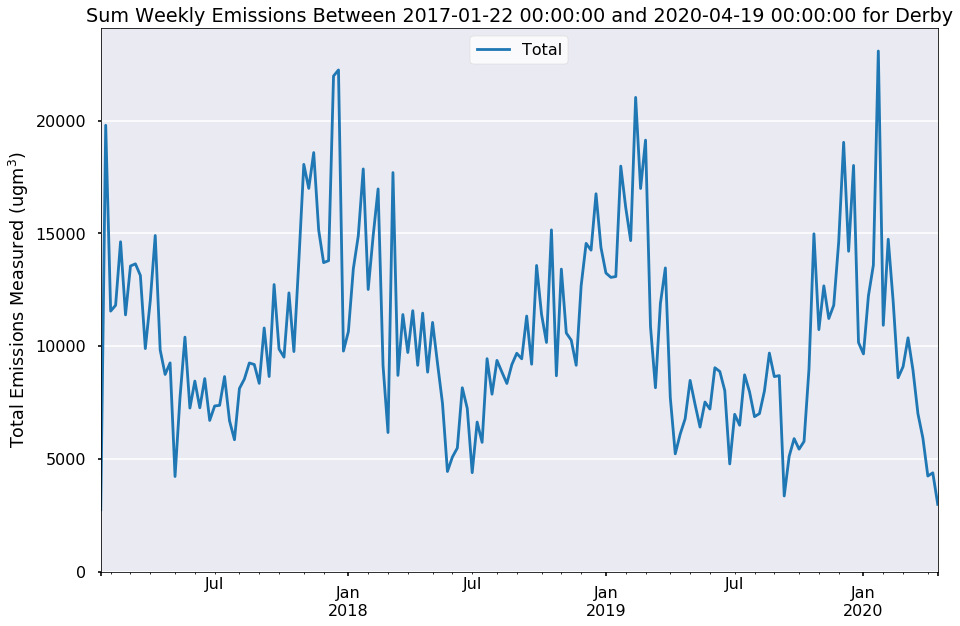

In [10]:
plot_date_range(start='2017-01-22',end='2020-04-19',resample_string='W',plottype='line',aggregate='sum',cols=1)

# "Rolling" calculation to assess trends

Text(0.5, 1.0, '365 Day Rolling Average Of Pollution From Derby Sensor')

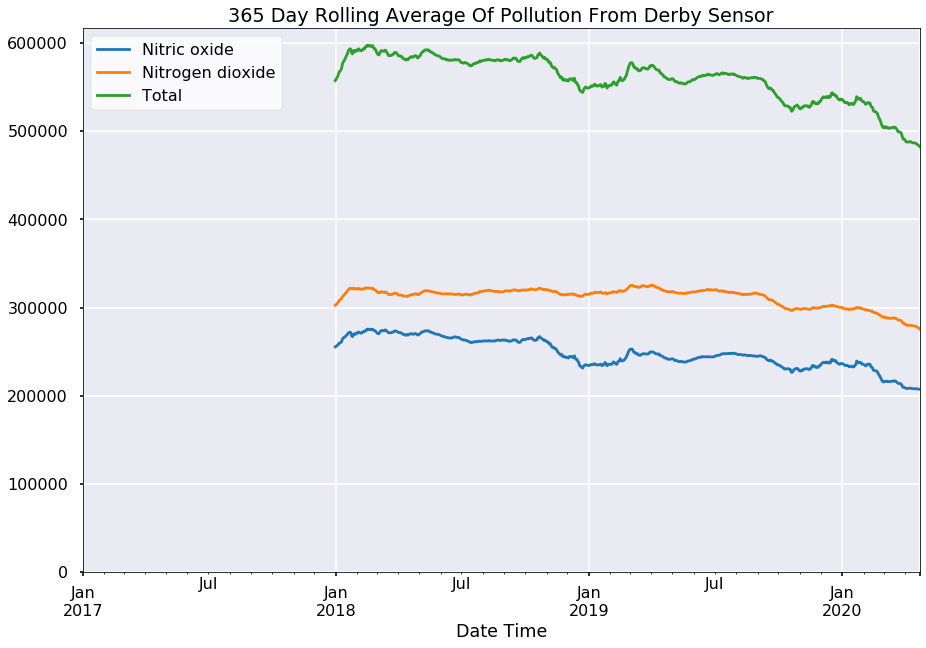

In [11]:
# Matplotlib plot
plt.style.use('seaborn-poster') # making the font bigger so it can be read on Instagram

# Make fig
fig = df_all[['Nitric oxide','Nitrogen dioxide',
             'Total']].resample('D').sum().rolling(365).sum().plot(figsize=[15,10])

# Stylings
fig.set_ylim(0,None)
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('365 Day Rolling Average Of Pollution From {} Sensor'.format(location_string))

#sns.axes_style({'axes.facecolour':'grey', 'axes.grid':True})

Text(0.5, 1.0, '365 Day Rolling Average Of Pollution From Derby Sensor, ZOOMED IN')

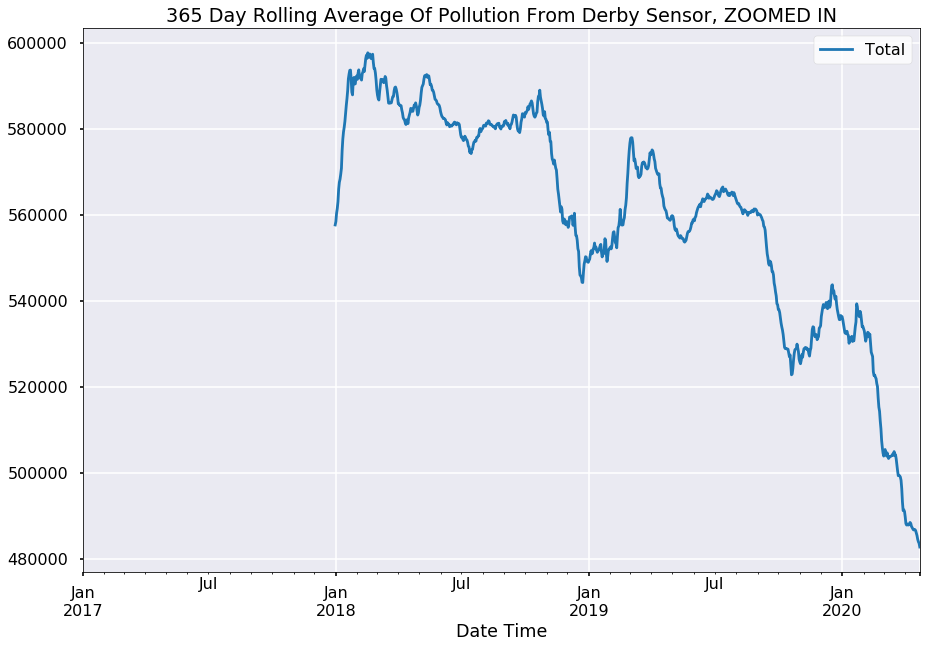

In [12]:
plt.style.use('seaborn-poster')
fig = df_all[['Total']].resample('D').sum().rolling(365).sum().plot(figsize=[15,10])

# Stylings
fig.set_ylim(None,None) # sets limits to be min and max of the data
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('365 Day Rolling Average Of Pollution From {} Sensor, ZOOMED IN'.format(location_string))

# Pollution per *hour*

Text(0, 0.5, 'ugm$^3$')

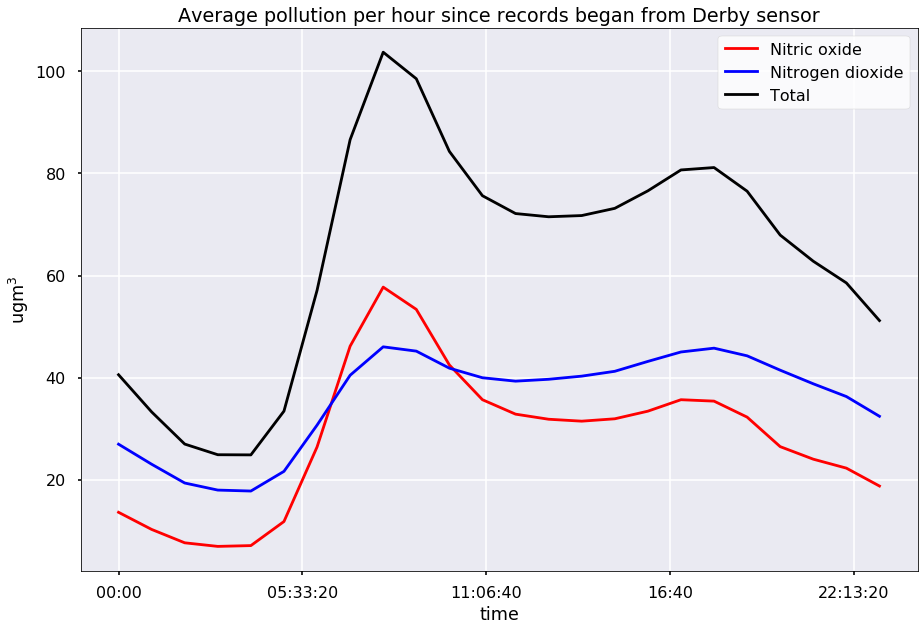

In [13]:
plt.style.use('seaborn-poster')


fig = df_all[['Nitric oxide','Nitrogen dioxide','Total']].groupby(df_all[['Nitric oxide','Nitrogen dioxide',
             'Total']].index.time).mean().plot(figsize=[15,10],color=['r','b','k'])

# Stylings
fig.set_ylim(None,None) # sets limits to be min and max of the data
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('Average pollution per hour since records began from {} sensor'.format(location_string))
plt.ylabel('ugm$^3$')

### 2020 hourly pollution

Text(0.5, 1.0, 'Average pollution per hour in 2020 from Derby sensor')

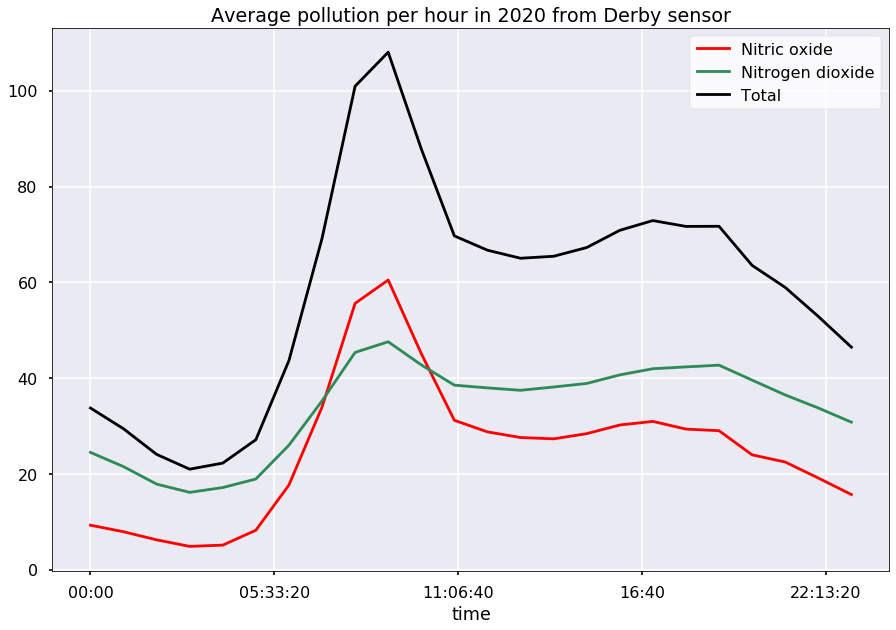

In [14]:
plt.style.use('seaborn-poster')

fig = df_2020[['Nitric oxide','Nitrogen dioxide','Total']
      ].groupby(df_2020[['Nitric oxide','Nitrogen dioxide',
             'Total']].index.time).mean().plot(figsize=[15,10],color=['r','seagreen','k'])

plt.title('Average pollution per hour in 2020')

# Stylings
fig.set_ylim(None,None) # sets limits to be min and max of the data
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('Average pollution per hour in 2020 from {} sensor'.format(location_string))

### Hourly pollution since 23rd of March (official lockdown date)

Text(0, 0.5, 'ugm$^3$')

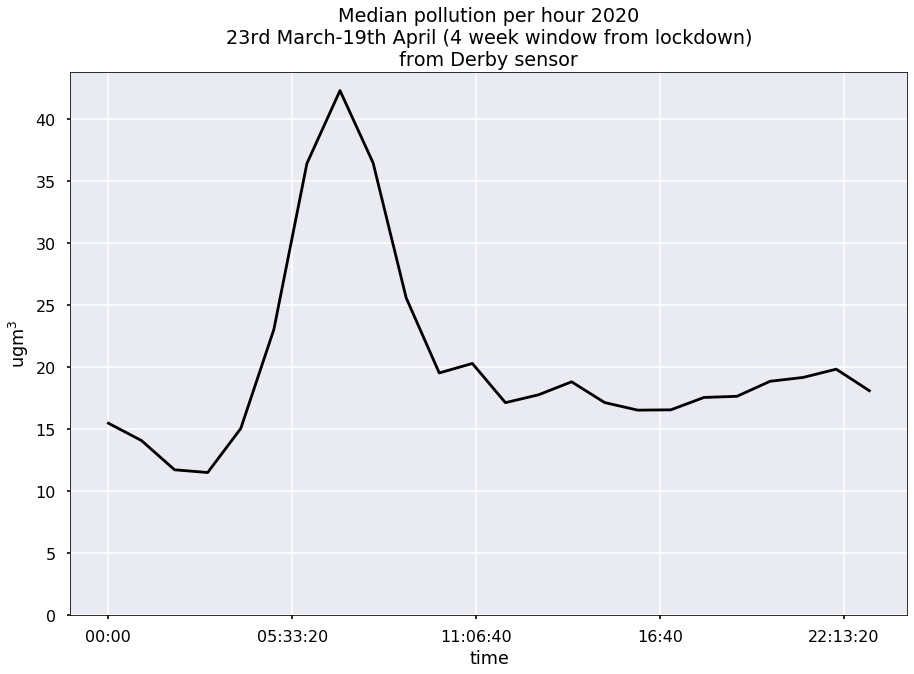

In [15]:
plt.style.use('seaborn-poster')

#fig = df_2020.loc['2020-03-21':][['Nitric oxide','Nitrogen dioxide','Total']
#      ].groupby(df_2020.loc['2020-03-21':][['Nitric oxide','Nitrogen dioxide',
#             'Total']].index.time).mean().plot(figsize=[15,10],color=['r','seagreen','k'])


fig = df_2020.loc['2020-03-21':]['Total'].groupby(df_2020.loc['2020-03-21':]['Total'].index.time).median().plot(figsize=[15,10],
                                                                                                              color=['k'])
# Stylings
fig.set_ylim(None,None) # sets limits to be min and max of the data
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('Median pollution per hour 2020\n23rd March-19th April (4 week window from lockdown)\nfrom {} sensor'.format(location_string))
fig.set_ylim(0,None)
plt.ylabel('ugm$^3$')

### Combined (2020 pre- and post-lockdown

Text(0.5, 0, '')

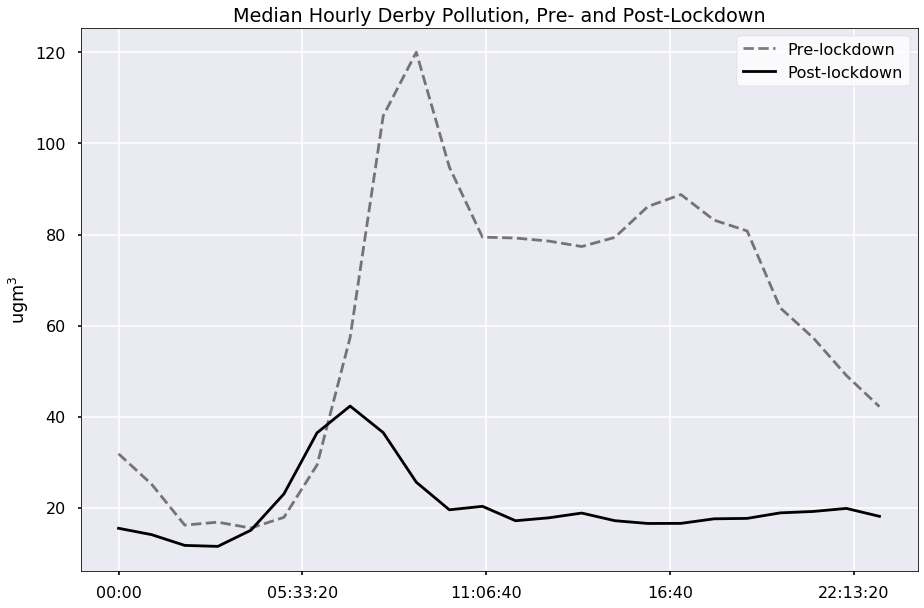

In [16]:
plt.style.use('seaborn-poster')

# 2020 pre-lockdown
fig = df_2020.loc['2020-01-01':'2020-03-20']['Total'].groupby(
    df_2020.loc['2020-01-01':'2020-03-20']['Total'].index.time).median().plot(figsize=[15,10],
                                                                        color=['k'],alpha=0.5, ls='--',
                                                                       label='Pre-lockdown')
# 2020 post-lockdown
fig = df_2020.loc['2020-03-21':]['Total'].groupby(
    df_2020.loc['2020-03-21':]['Total'].index.time).median().plot(
    figsize=[15,10],color=['k'], label='Post-lockdown')

# Stylings
plt.title('Average pollution per hour in 2020')
plt.legend()
fig.set_ylim(None,None) # sets limits to be min and max of the data
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('Median Hourly {} Pollution, Pre- and Post-Lockdown'.format(location_string))
plt.ylabel('ugm$^3$')
plt.xlabel('')

#plt.savefig('Derby images/10. Median Hourly Pollution Pre- and Post-Lockdown.png')

- Just realised above isn't fair as it's comparing Q1 data to post-lockdown which is lower anyway 
- Will compare March 2019 to March 2020?

(0, 122.0285915)

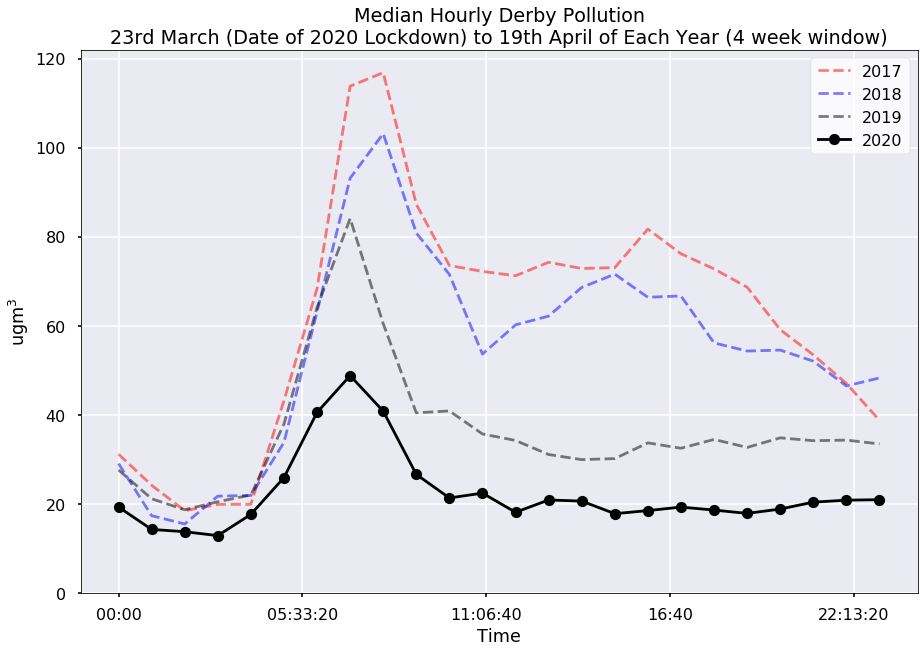

In [17]:
plt.style.use('seaborn-poster')

# 2017 March hourly 
fig = df_2017.loc['2017-03-23':'2017-04-19']['Total'].groupby(
    df_2017.loc['2017-03-23':'2017-04-19']['Total'].index.time).median().plot(figsize=[15,10],
                                                                        color=['r'],alpha=0.5, ls='--',
                                                                       label='2017')
# 2018 March hourly 
fig = df_2018.loc['2018-03-23':'2018-04-19']['Total'].groupby(
    df_2018.loc['2018-03-23':'2018-04-19']['Total'].index.time).median().plot(figsize=[15,10],
                                                                        color=['b'],alpha=0.5, ls='--',
                                                                       label='2018')
# 2019 March hourly 
fig = df_2019.loc['2019-03-23':'2019-04-19']['Total'].groupby(
    df_2019.loc['2019-03-23':'2019-04-19']['Total'].index.time).median().plot(figsize=[15,10],
                                                                        color=['k'],alpha=0.5, ls='--',
                                                                       label='2019')
# 2020 March hourly 
fig = df_2020.loc['2020-03-23':'2020-04-19']['Total'].groupby(
    df_2020.loc['2020-03-23':'2020-04-19']['Total'].index.time).median().plot(
    figsize=[15,10],color=['k'], label='2020',marker='o')

# Stylings
plt.legend()
fig.set_ylim(None,None) # sets limits to be min and max of the data
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('Median Hourly {} Pollution\n23rd March (Date of 2020 Lockdown) to 19th April of Each Year (4 week window)'.format(location_string))
plt.ylabel('ugm$^3$')
plt.xlabel('Time')
fig.set_ylim(0,None)
#plt.savefig('Derby images/11. Median Hourly Pollution Pre- and Post-Lockdown.png')

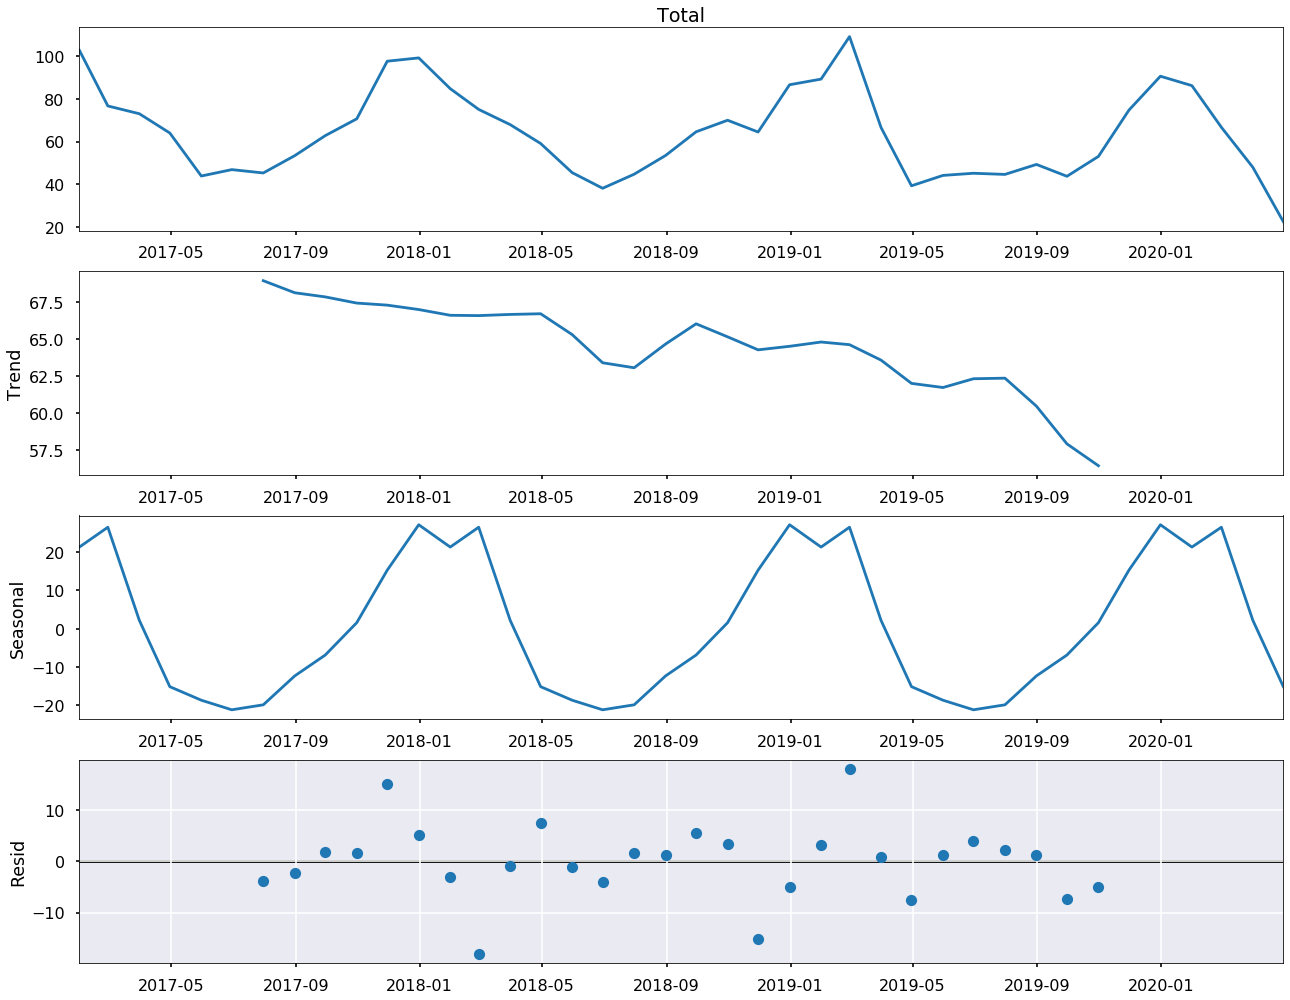

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 14
y = df_all['Total'].resample('M').mean()
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()

# Stylings
ax = fig.gca() # not entirely sure what this does but it lets me make an ax after the fact for editing!
ax.set_facecolor('#eaeaf2')
plt.grid(True,color='w')

# Comparing multiple years on one plot

In [19]:
# Compare years on the same plot, by either hourly or daily data
# Should try and rebuild this function as I've made it in a very clunky way, but hey it works!
# To do - replace masks with .loc
def year_comparison(start,end,resample_string,years_of_data):
    '''Compare years on the same plot, by either hourly or daily data
    
    Keyword arguments:
    start = string of date in format 'MM-DD'
    end = string of date in format 'MM-DD'
    resample_string = 'H','D'
    years_of_data = 1, 2, 3 or 4, determines how many years to plot
    '''
    global df_2020, df_2019, df_2018, df_2017
    
    # Turn inputted start and date "MM-DD" to the 4 years "YYYY-MM-DD" for use to get necessary data
    start_2020 = '2020-' + start
    start_2020 = pd.to_datetime(start_2020)
    end_2020 = '2020-' + end
    end_2020 = pd.to_datetime(end_2020)
    
    start_2019 = '2019-' + start
    start_2019 = pd.to_datetime(start_2019)
    end_2019 = '2019-' + end
    end_2019 = pd.to_datetime(end_2019)
       
    start_2018 = '2018-' + start
    start_2018 = pd.to_datetime(start_2018)
    end_2018 = '2018-' + end
    end_2018 = pd.to_datetime(end_2018)
    
    start_2017 = '2017-' + start
    start_2017 = pd.to_datetime(start_2017)
    end_2017 = '2017-' + end
    end_2017 = pd.to_datetime(end_2017)
    
    # Returning new dataframes df_2020_ etc for each year between the requested dates ###
    df_2020_ = df_2020.loc[start_2020:end_2020]
    df_2019_ = df_2019.loc[start_2019:end_2019]
    df_2018_ = df_2018.loc[start_2018:end_2018]
    df_2017_ = df_2017.loc[start_2017:end_2017]
    
    ### HOURLY PLOT ###
    if resample_string=='H':
        ### Making date time no year column
        df_2020_['Date Time No Year'] = df_2020_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2019_['Date Time No Year'] = df_2019_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2018_['Date Time No Year'] = df_2018_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2017_['Date Time No Year'] = df_2017_['Date Time'].dt.strftime('%m-%d %H:%M')

        ### Plotting them with date time no year
        plt.figure(figsize=(15,10))
        
        if years_of_data==4:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                        label = '2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Total'],
                        label = '2019 Total Pollution',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Total'],
                        label = '2018 Total Pollution',alpha=0.6,linestyle=':',color='#FF9914')
            sns.lineplot(x=df_2017_['Date Time No Year'],y=df_2017_['Total'],
                        label ='2017 Total Pollution',alpha=0.6,linestyle='-.',color='#EC4E20')
        
        elif years_of_data==3:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                    label = '2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Total'],
                        label = '2019 Total Pollution',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Total'],
                        label = '2018 Total Pollution',alpha=0.6,linestyle=':',color='#FF9914')
    
        elif years_of_data==2:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                    label = '2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                        label = '2019 Total Pollution',linestyle=':',alpha=0.6,color='#775253')
            
        elif years_of_data==1:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                    label = '2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
    
        # Stylings
        plt.xticks(rotation=90) # would be great to strip the hours from the x ticks
        plt.xlabel('')
        plt.ylabel('Total Pollution NO + NO\N{SUBSCRIPT TWO} (ugm$^3$))')
        plt.title('Hourly Total Pollution (NO + NO\N{SUBSCRIPT TWO}) Emissions From Date {} to {} of Each Year'.format(start,end))
        plt.legend(loc='upper center')
        plt.xticks('')
        ax = plt.gca() # not entirely sure what this does but it lets me make an ax after the fact for editing!
        ax.set_facecolor('#eaeaf2')
        plt.grid(True,color='w')
    
    ### DAILY PLOT ###
    elif resample_string!='H':
        ### Resample accordingly (however only by day works)
        plt.figure(figsize=(15,10))
        df_2020_ = df_2020_.resample(resample_string).sum()
        df_2019_ = df_2019_.resample(resample_string).sum()
        df_2018_ = df_2018_.resample(resample_string).sum()
        df_2017_ = df_2017_.resample(resample_string).sum()
                
        ### Making date time no year column
        df_2020_['Date Time No Year'] = df_2020_.index.strftime('%m-%d %H:%M')
        df_2019_['Date Time No Year'] = df_2019_.index.strftime('%m-%d %H:%M')
        df_2018_['Date Time No Year'] = df_2018_.index.strftime('%m-%d %H:%M')
        df_2017_['Date Time No Year'] = df_2017_.index.strftime('%m-%d %H:%M')
        
        #### Replacing date time as index as removing datatime column 
        def cleaner(variable):
            variable.index = variable['Date Time No Year']

        cleaner(df_2020_)
        cleaner(df_2019_)
        cleaner(df_2018_)
        cleaner(df_2017_)

        plt.figure(figsize=(15,10))
        if years_of_data==4:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                         label='2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Total'],
                         label='2019 Total Pollution',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Total'],
                         label='2018 Total Pollution',alpha=0.6,linestyle=':',color='#FF9914')
            sns.lineplot(x=df_2017_['Date Time No Year'],y=df_2017_['Total'],
                         label='2017 Total Pollution',alpha=0.6,linestyle='-.',color='#EC4E20')
            
        elif years_of_data==3:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                         label='2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Total'],
                         label='2019 Total Pollution',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Total'],
                         label='2018 Total Pollution',alpha=0.6,linestyle=':',color='#FF9914')

        elif years_of_data==2:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                         label='2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Total'],
                         label='2019 Total Pollution',linestyle=':',alpha=0.6,color='#775253')

        elif years_of_data==1:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                         label='2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
        
        # Stylings
        plt.xticks(rotation=90) # would be great to strip the hours from the x ticks
        plt.xticks('')
        plt.xlabel('')
        plt.ylabel('Total Pollution (NO + NO\N{SUBSCRIPT TWO} (ugm$^3$))')
        plt.title('Daily Total Pollution (NO + NO\N{SUBSCRIPT TWO}) Emissions From Date {} to {} of Each Year'.format(start,end))
        plt.legend(loc='upper center')
        ax = plt.gca() # not entirely sure what this does but it lets me make an ax after the fact for editing!
        ax.set_facecolor('#eaeaf2')
        plt.grid(True,color='w')

<Figure size 1080x720 with 0 Axes>

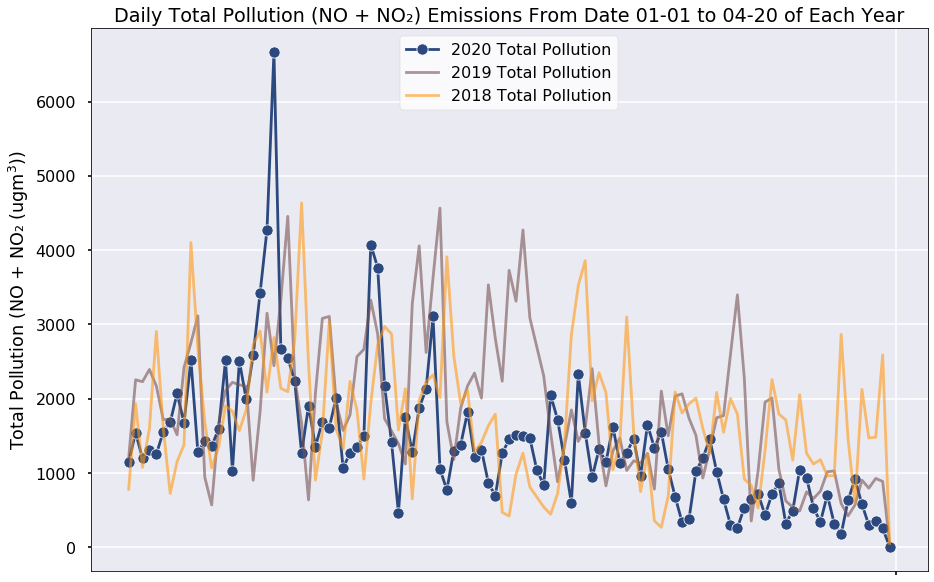

In [20]:
year_comparison(start='01-01',end='04-20',resample_string='D',years_of_data=3) 

# Pivot tables

## 1) Plot each year by week number

In [85]:
dayofweek = datetime.today().weekday()
last_sunday = datetime.today().date()-timedelta(days=dayofweek+1)
last_sunday

datetime.date(2020, 4, 19)

In [86]:
# Making weekly pivot table (of only full weeks)
#df_all_ = df_all.loc['2017-01-01':'2020-04-19'] # so it only plots full weeks
df_all_ = df_all.loc['2017-01-01':last_sunday] # so it only plots full weeks
weekly = df_all_.resample('W').sum()
pivoted = weekly.pivot_table('Total', index=[weekly.index.week], columns=weekly.index.year)
pivoted.columns=['2017','2018','2019','2020']

(0, 25000)

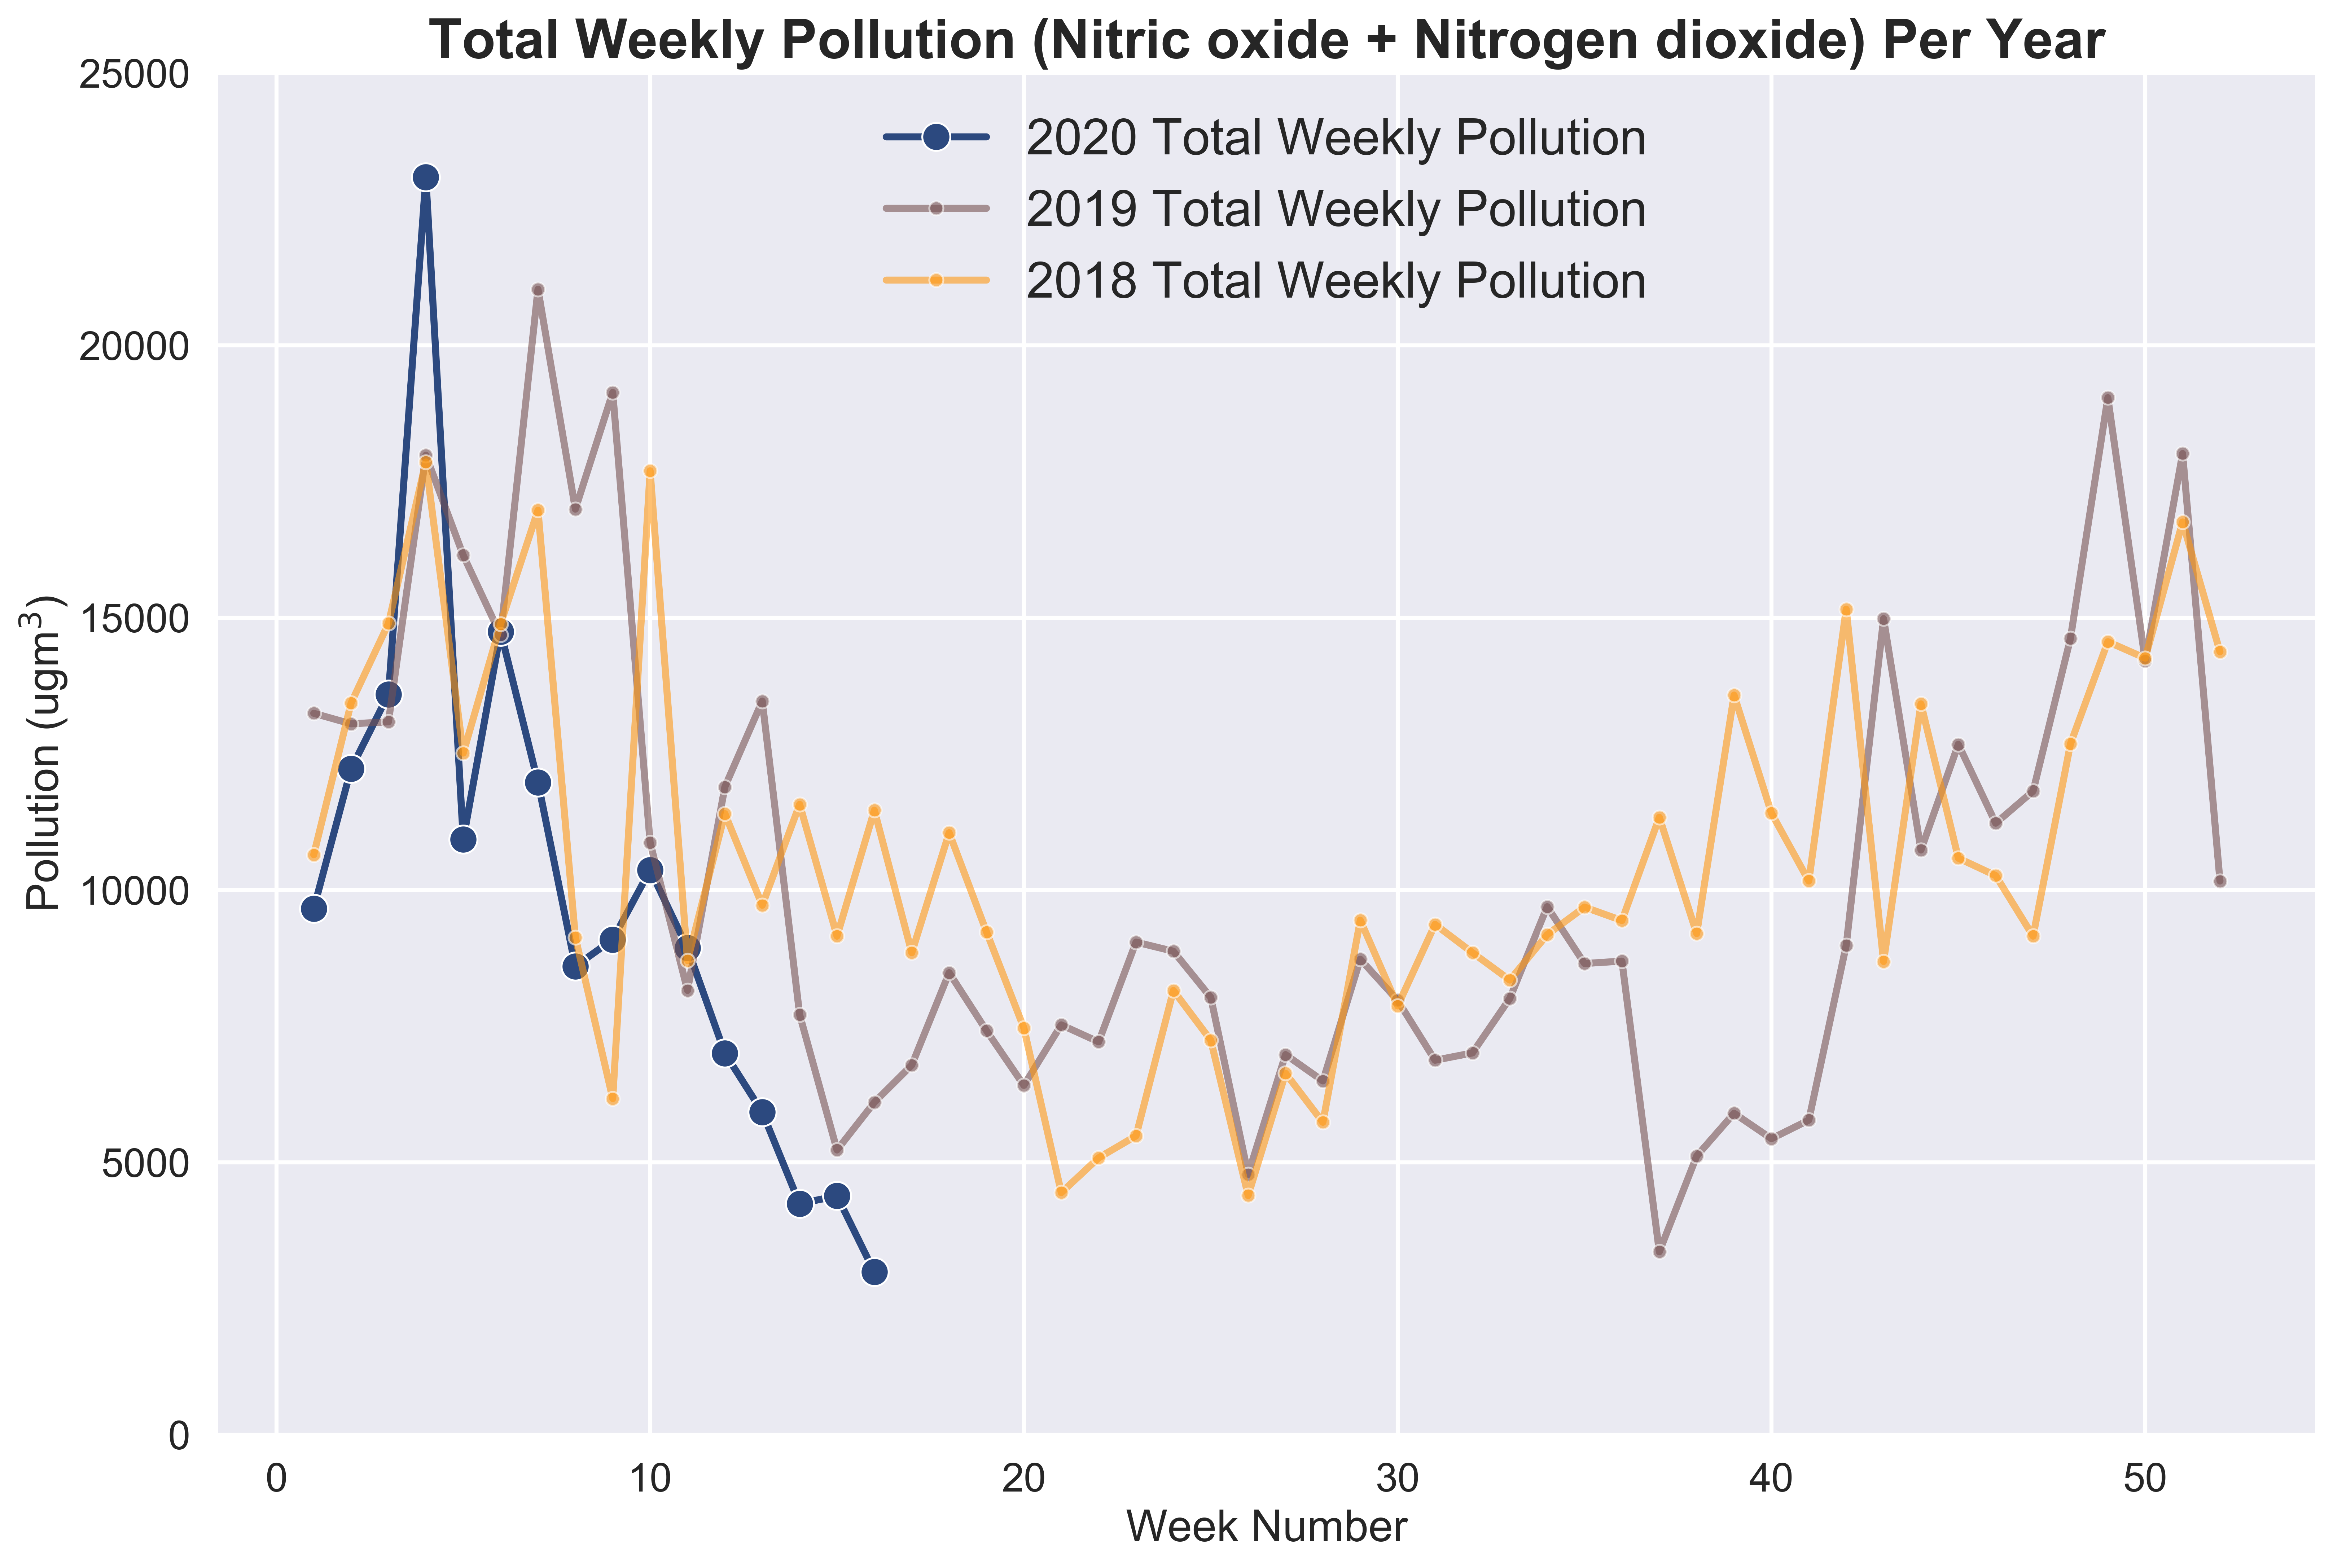

In [87]:
# plotting data
plt.style.use('seaborn')
plt.style.use('seaborn-poster')

x = plt.figure(figsize=(15,10),dpi=500)
x = sns.lineplot(x=pivoted.index,y=pivoted['2020'],label='2020 Total Weekly Pollution',
             marker='o',alpha=1,color='#2C497F',ci=None)
x = sns.lineplot(x=pivoted.index,y=pivoted['2019'],label='2019 Total Weekly Pollution',
             alpha=0.6,color='#775253',marker='.',ci=None)
x = sns.lineplot(x=pivoted.index,y=pivoted['2018'],label='2018 Total Weekly Pollution',
             alpha=0.6,color='#FF9914',marker='.',ci=None)
#sns.lineplot(x=pivoted.index,y=pivoted['2017'],label='2017 Total Weekly Pollution',
#             alpha=0.6,color='#EC4E20',marker='.',ci=None)


#plt.axvline(13, 0, 1,color='k',alpha=0.3,ls='--')

# Arrow and annotation to explain horizonal line 
#plt.annotate(s='Week 13: \n(23rd of March)\nOfficial Date of Lockdown',
#                     xy=(0.27,0.63),
#                     xytext=(0.35,0.67), 
#                     xycoords='axes fraction',
#                     textcoords='axes fraction',
#                    arrowprops=dict(width=1,fc='k'),
#                    fontsize=15,
#                    fontweight='bold')


# plot stylings
plt.legend(loc='upper center',fontsize=20)
plt.ylabel('Pollution (ugm$^3$)')
plt.xlabel('Week Number')
plt.title('Total Weekly Pollution (Nitric oxide + Nitrogen dioxide) Per Year',fontdict={'fontweight':'bold','fontsize':22})
x.set_ylim(0,25000)

#plt.savefig('Derby images/01. Weekly Pollution.png')

### Pivot table showing *only some* weeks of the year, to improve readability

In [23]:
# First, make pivot table
pivoted_limited = pivoted.iloc[0:20]

Text(0.5, 1.0, 'Total Weekly Pollution (Nitric oxide + Nitrogen dioxide) Per Year')

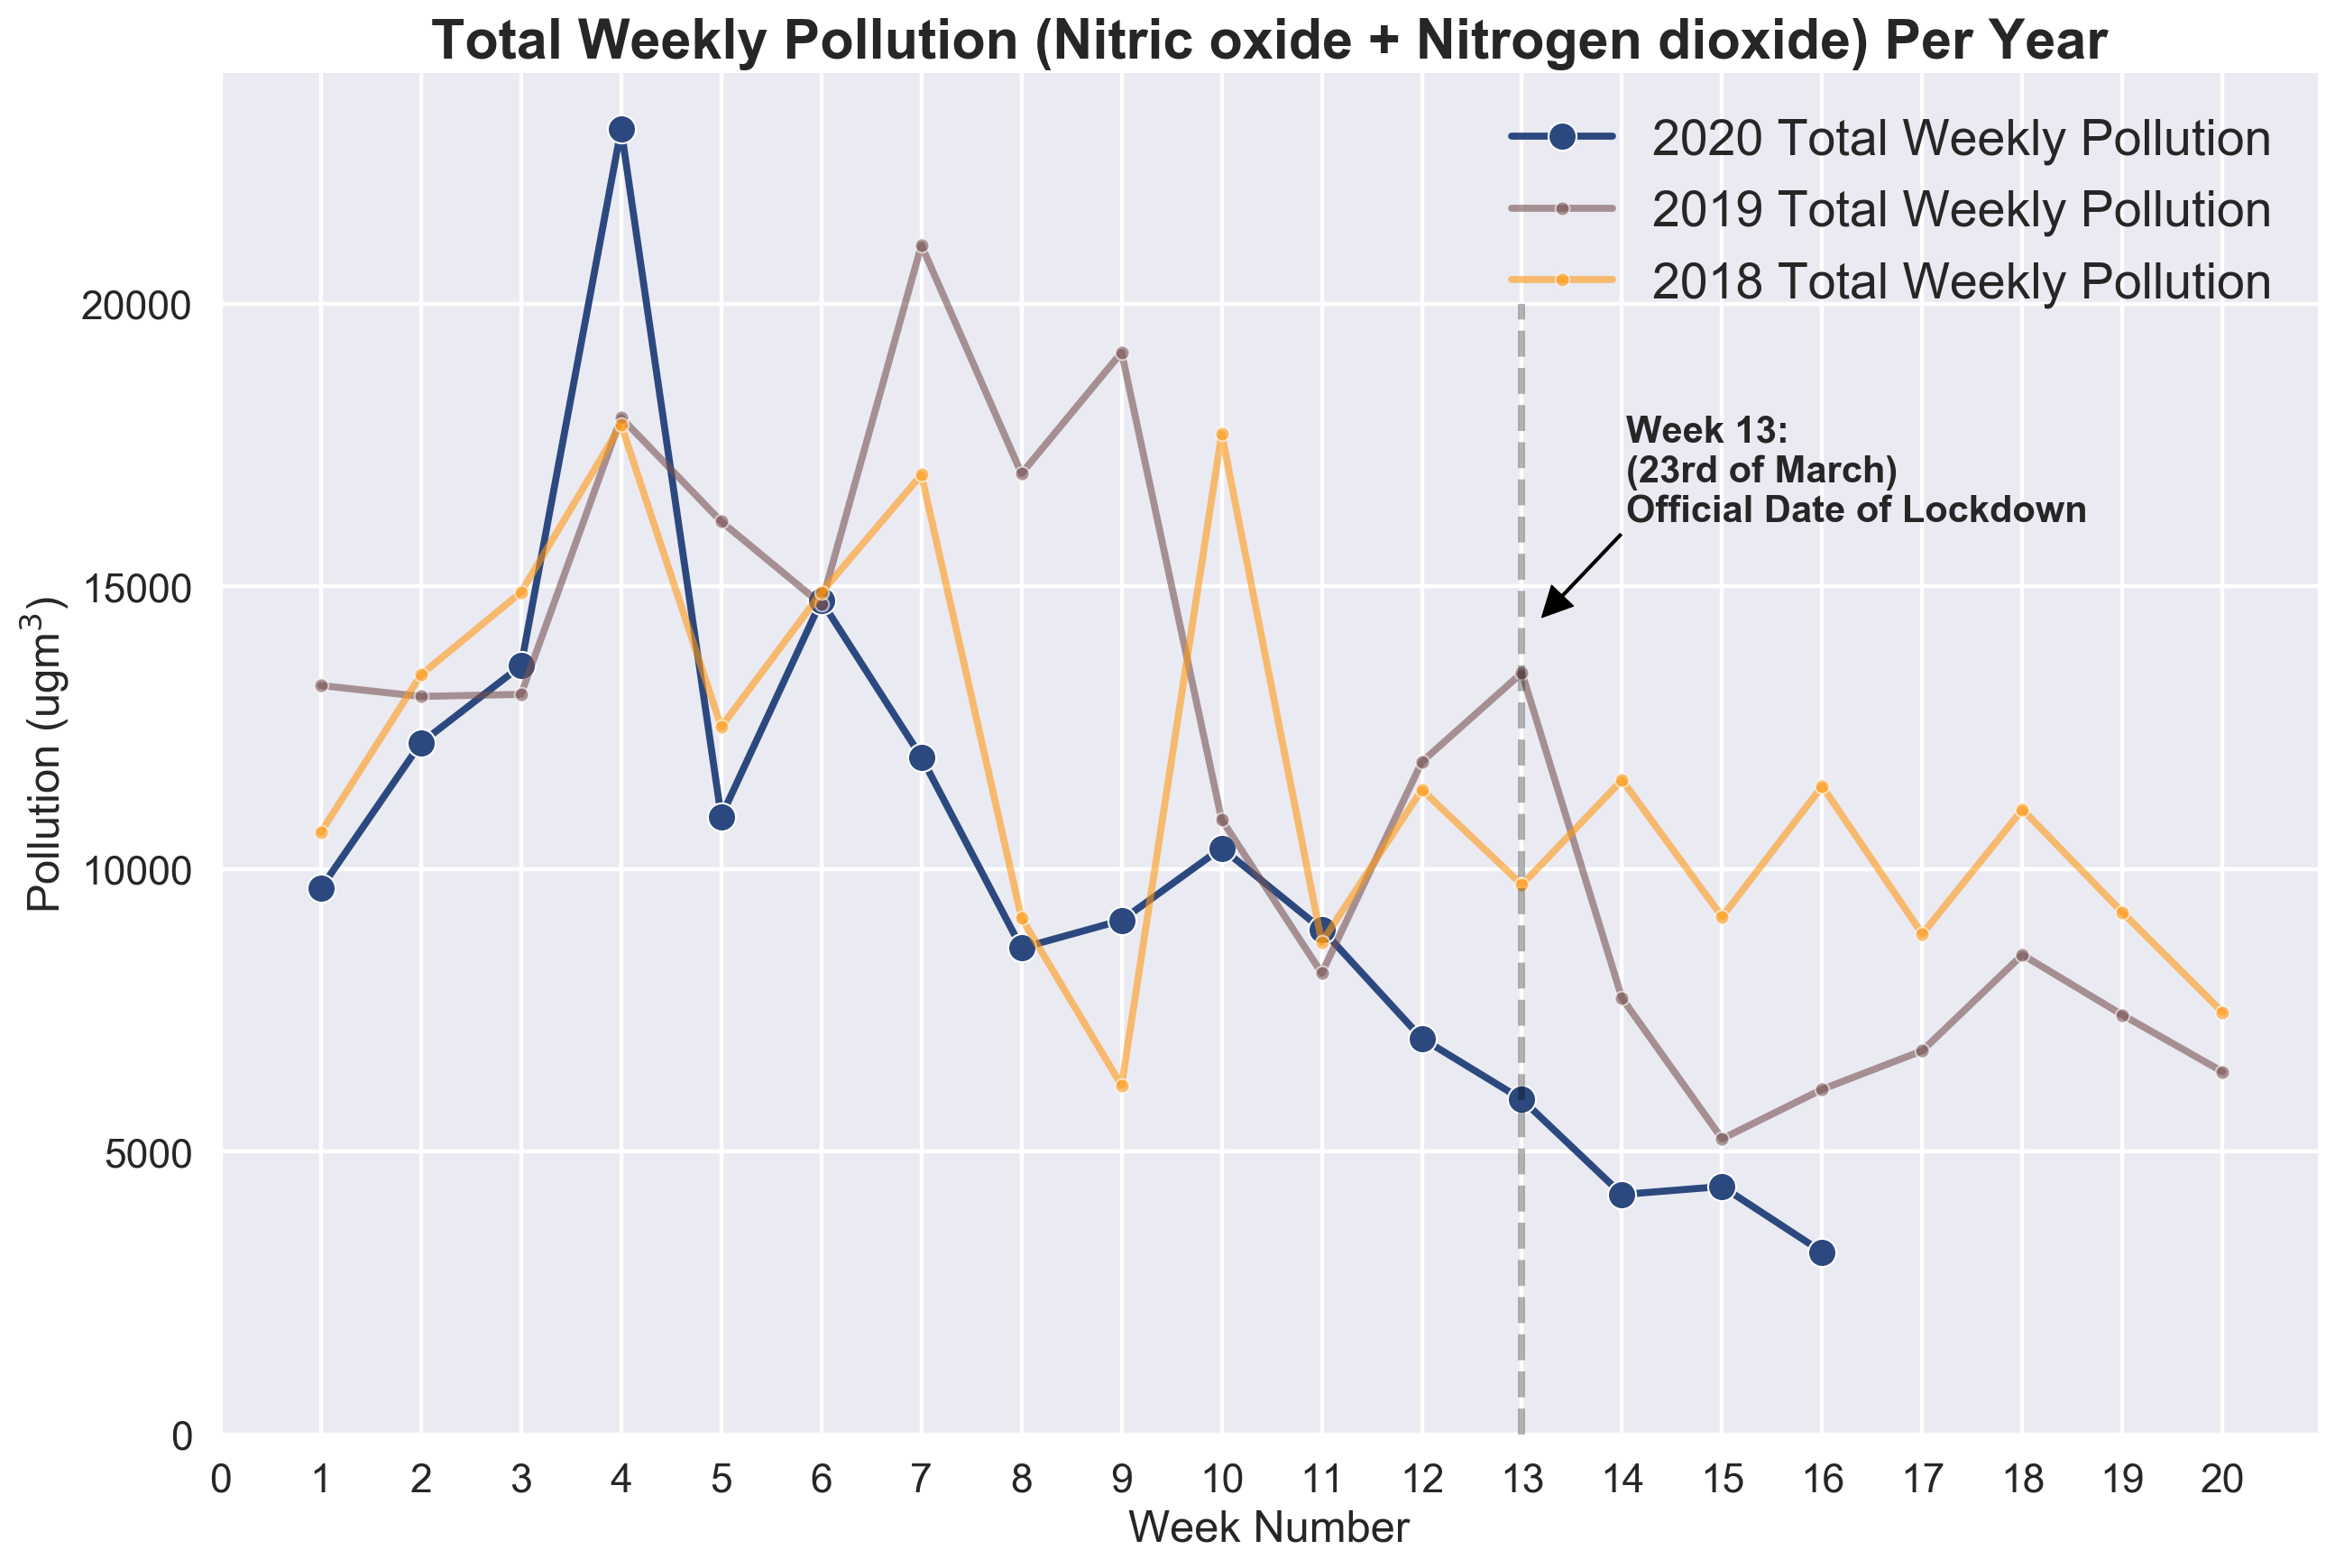

In [24]:
# plotting data
x = plt.figure(figsize=(15,10),dpi=200)
x = sns.lineplot(x=pivoted_limited.index,y=pivoted_limited['2020'],label='2020 Total Weekly Pollution',
             marker='o',alpha=1,color='#2C497F',ci=None)
x = sns.lineplot(x=pivoted_limited.index,y=pivoted_limited['2019'],label='2019 Total Weekly Pollution',
             alpha=0.6,color='#775253',marker='.',ci=None)
x = sns.lineplot(x=pivoted_limited.index,y=pivoted_limited['2018'],label='2018 Total Weekly Pollution',
             alpha=0.6,color='#FF9914',marker='.',ci=None)
#sns.lineplot(x=pivoted.index,y=pivoted['2017'],label='2017 Total Weekly Pollution',
#             alpha=0.6,color='#EC4E20',marker='.',ci=None)

plt.axvline(13, 0, 0.83,color='k',alpha=0.3,ls='--')

# Arrow and annotation to explain horizonal line 
plt.annotate(s='Week 13: \n(23rd of March)\nOfficial Date of Lockdown',
                     xy=(0.63,0.60),
                     xytext=(0.67,0.67), 
                     xycoords='axes fraction',
                     textcoords='axes fraction',
                    arrowprops=dict(width=1,fc='k'),
                    fontsize=15,
                    fontweight='bold')

# plot stylings
plt.style.use('seaborn-poster')
plt.legend(loc='upper right',fontsize=20)
plt.ylabel('Pollution (ugm$^3$)')
plt.xlabel('Week Number')
x.set_ylim(0,None)
plt.xticks(np.arange(21),np.arange(21))
plt.title('Total Weekly Pollution (Nitric oxide + Nitrogen dioxide) Per Year',fontdict={'fontweight':'bold','fontsize':22})

#plt.savefig('Derby images/02. Weekly Pollution Zoomed.png')

# Comparing 2020 to median value of previous years (easier to read)

In [25]:
# Making new column in pivot table: median of 2017 & 2018 & 2019
z = pivoted.loc[:,['2017','2018','2019']].median(axis=1)
pivoted['Median Over Previous Years'] = z

# Making new column in pivot table: mean of 2017 & 2018 & 2019 9 (why not)
y = pivoted.loc[:,['2017','2018','2019']].mean(axis=1)
pivoted['Mean Over Previous Years'] = y

# New columns: 2020 as % of median, and 2020 % change from median
pivoted['% Of Median'] = (pivoted['2020']/pivoted['Median Over Previous Years'])*100
pivoted['% Change From Median'] = ((pivoted['2020']/pivoted['Median Over Previous Years'])-1)*100

# Column to indicate if weekly value for 2020 is higher or lower than median 
pivoted.loc[pivoted['% Of Median'] >= 100, 'High Or Low'] = 'Higher Than Median'
pivoted.loc[pivoted['% Of Median'] < 100, 'High Or Low'] = 'Lower Than Median'

# New dataframe containing just median of previous years, 2020, % of median, % change from median, mean (i.e. dropp prev years)
pivoted_clean = pivoted.iloc[:,[4,3,5,6,7,8]]

# Making smaller "limited" pivot_clean not showing all weeks
pivoted_clean_limited = pivoted_clean.iloc[:20,:]

### Heatmap of 2017 vs 2018 vs 2019 vs 2020 total weekly pollution

Text(0.5, 1, 'Total Pollution Measured Per Week Of Each Year')

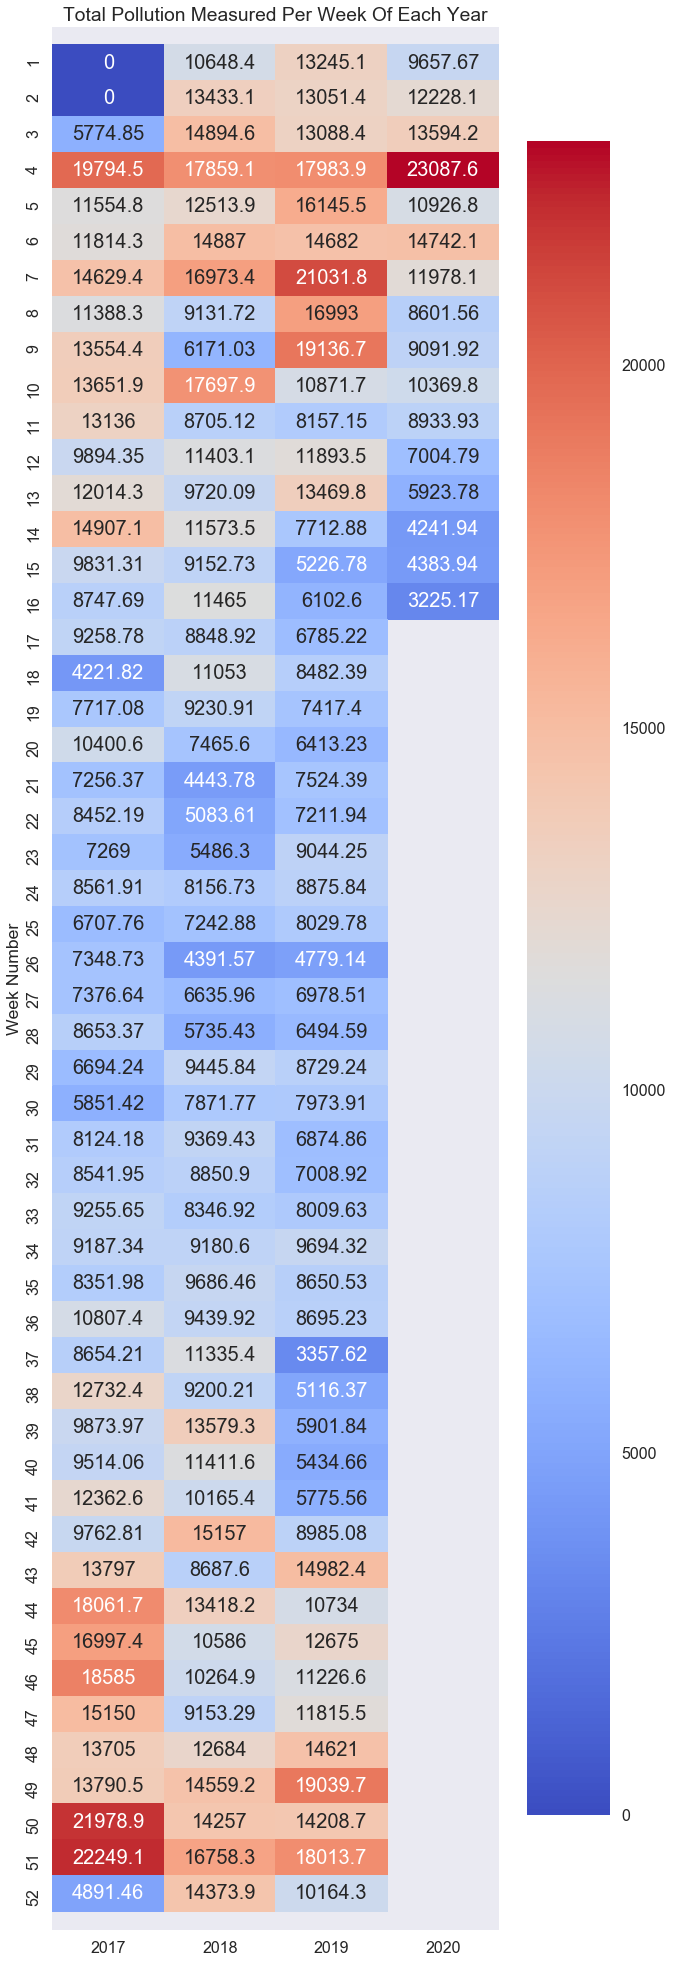

In [26]:
fig, ax = plt.subplots(figsize=(10,35))         # Sample figsize in inches
#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(pivoted[['2017','2018','2019','2020']],cmap='coolwarm',annot=True,fmt='g',annot_kws={"size": 20},ax=ax)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ylabel('Week Number')
title('Total Pollution Measured Per Week Of Each Year')

### Heatmap of 2017 & 2018 & 2019 median weekly pollution vs 2020 weekly pollution

Text(0.5, 1, '2020 Weekly Pollution Compared To Median Pollution of Previous 3 Years')

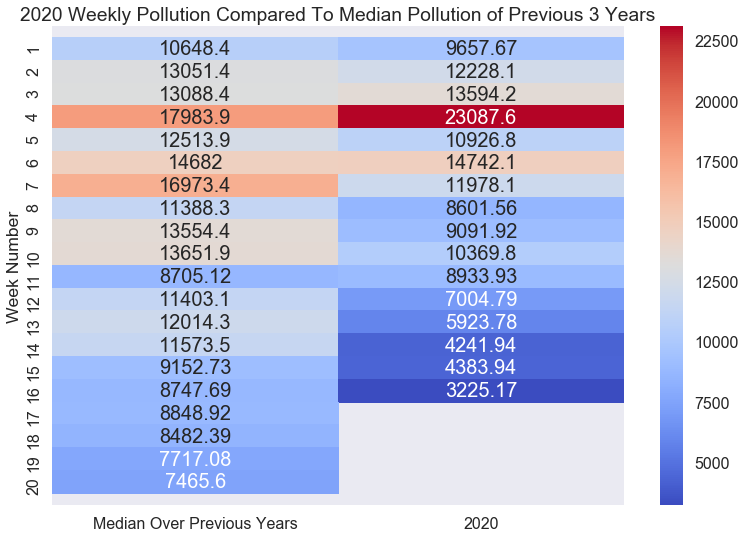

In [27]:
ax = sns.heatmap(pivoted_clean_limited[['Median Over Previous Years','2020']],
                 cmap='coolwarm',annot=True,fmt='g',annot_kws={"size": 20})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ylabel('Week Number')
title('2020 Weekly Pollution Compared To Median Pollution of Previous 3 Years')
#xticks(np.arange(2),['Median Total Pollution Of 2017, 2018 and 2019','2020 Weekly Total Pollution'])
#plt.savefig('Derby Images/07. Weekly Pollution 2020 vs Median of Previous Years.png')

### Above heatmap as line plot

Text(0.5, 1.0, 'Total Weekly Pollution Detected, 2020 vs Mean & Median of 2017 + 2018 + 2019')

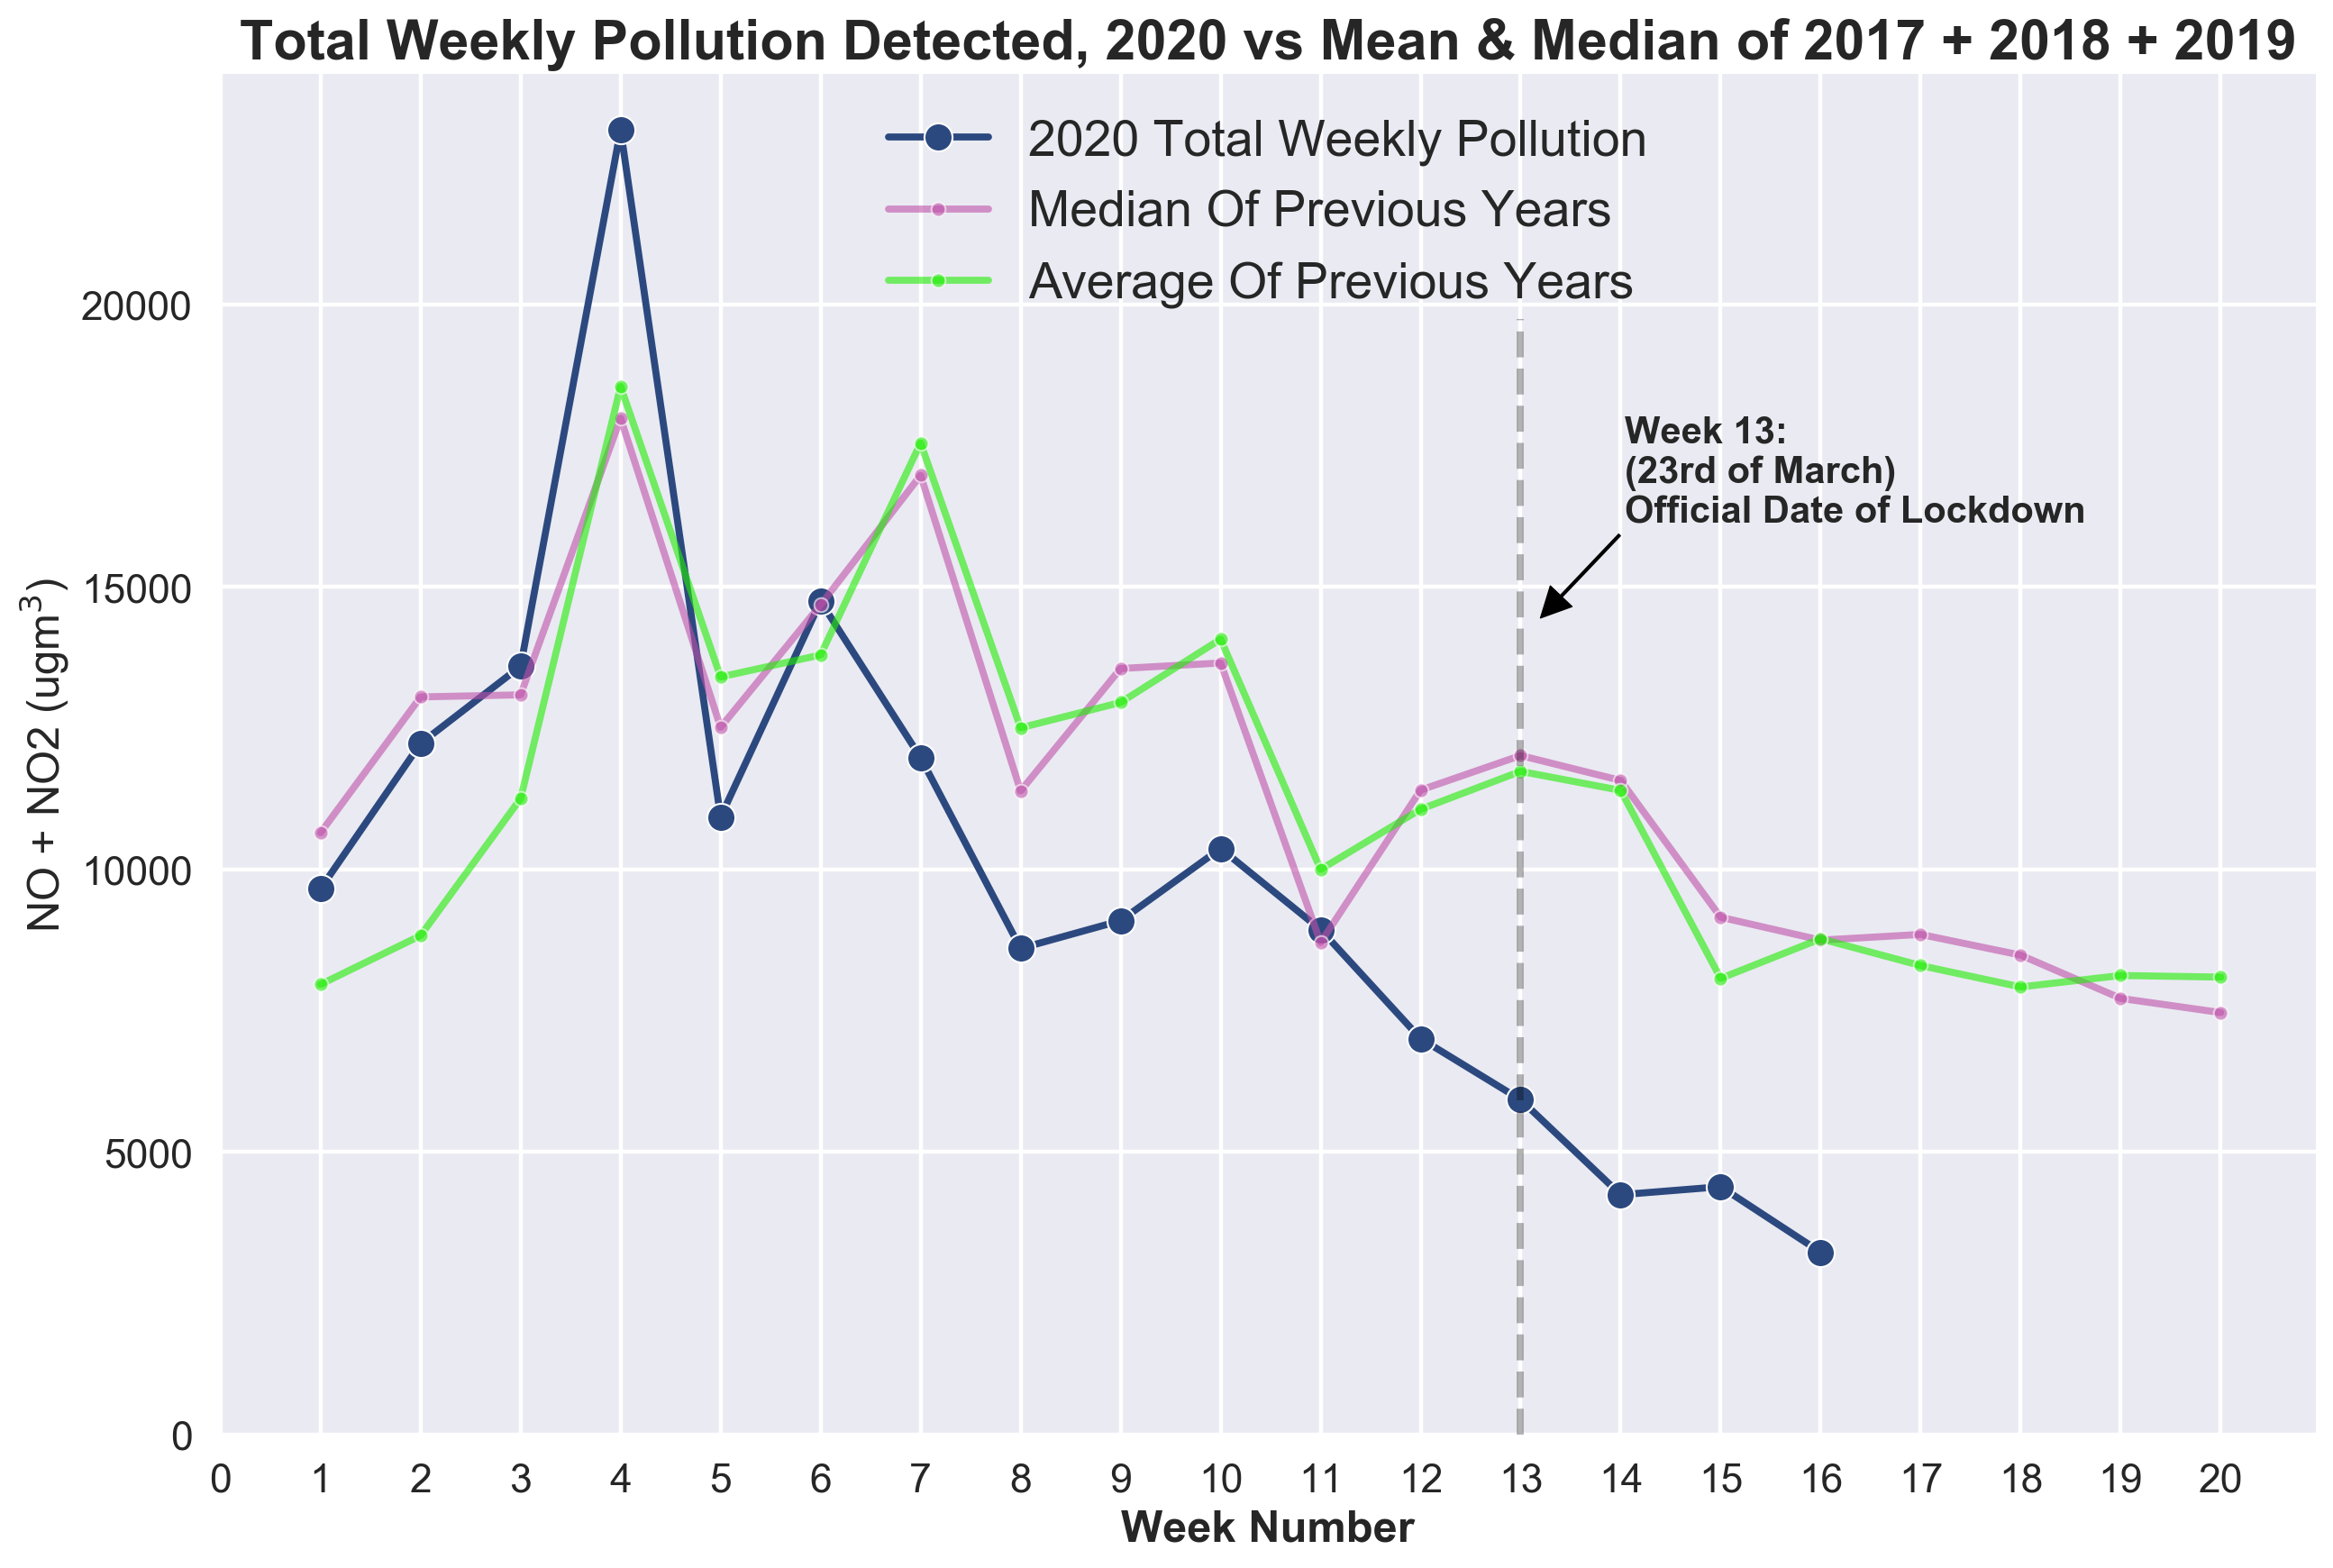

In [28]:
# plotting data
x = plt.figure(figsize=(15,10),dpi=200)
x = sns.lineplot(x=pivoted_clean_limited.index,y=pivoted_clean_limited['2020'],label='2020 Total Weekly Pollution',
             marker='o',alpha=1,color='#2C497F',ci=None)
x = sns.lineplot(x=pivoted_clean_limited.index,y=pivoted_clean_limited['Median Over Previous Years'],
                 label='Median Of Previous Years',alpha=0.6,color='#be51a9',marker='.',ci=None)
x = sns.lineplot(x=pivoted_clean_limited.index,y=pivoted_clean_limited['Mean Over Previous Years'],
                 label='Average Of Previous Years',alpha=0.6,color='#1fed03',marker='.',ci=None)

plt.axvline(13, 0, 0.82,color='k',alpha=0.3,ls='--')

# Arrow and annotation to explain horizonal line 
plt.annotate(s='Week 13: \n(23rd of March)\nOfficial Date of Lockdown',
                     xy=(0.63,0.60),
                     xytext=(0.67,0.67), 
                     xycoords='axes fraction',
                     textcoords='axes fraction',
                    arrowprops=dict(width=1,fc='k'),
                    fontsize=15,
                    fontweight='bold')


# plot stylings
plt.style.use('seaborn-poster')
plt.legend(loc='upper center',fontsize=20)
plt.ylabel('NO + NO2 (ugm$^3$)')
#plt.ylabel('Nitric oxide + Nitrogen dioxide (ugm$^3$)')
plt.xlabel('Week Number',fontdict={'fontweight':'bold'})
x.set_ylim(0,None)
plt.xticks(np.arange(21),np.arange(21))
plt.title('Total Weekly Pollution Detected, 2020 vs Mean & Median of 2017 + 2018 + 2019',
         fontdict={'fontweight':'bold','fontsize':22})
#plt.savefig('Derby Images/03. Weekly 2020 Pollution VS Mean and Median Of Previous Years.png')

# would be great to also say % drop compared to median and mean

Text(0.5, 1.0, 'Total Weekly Pollution Detected, 2020 vs Mean & Median of 2017 + 2018 + 2019')

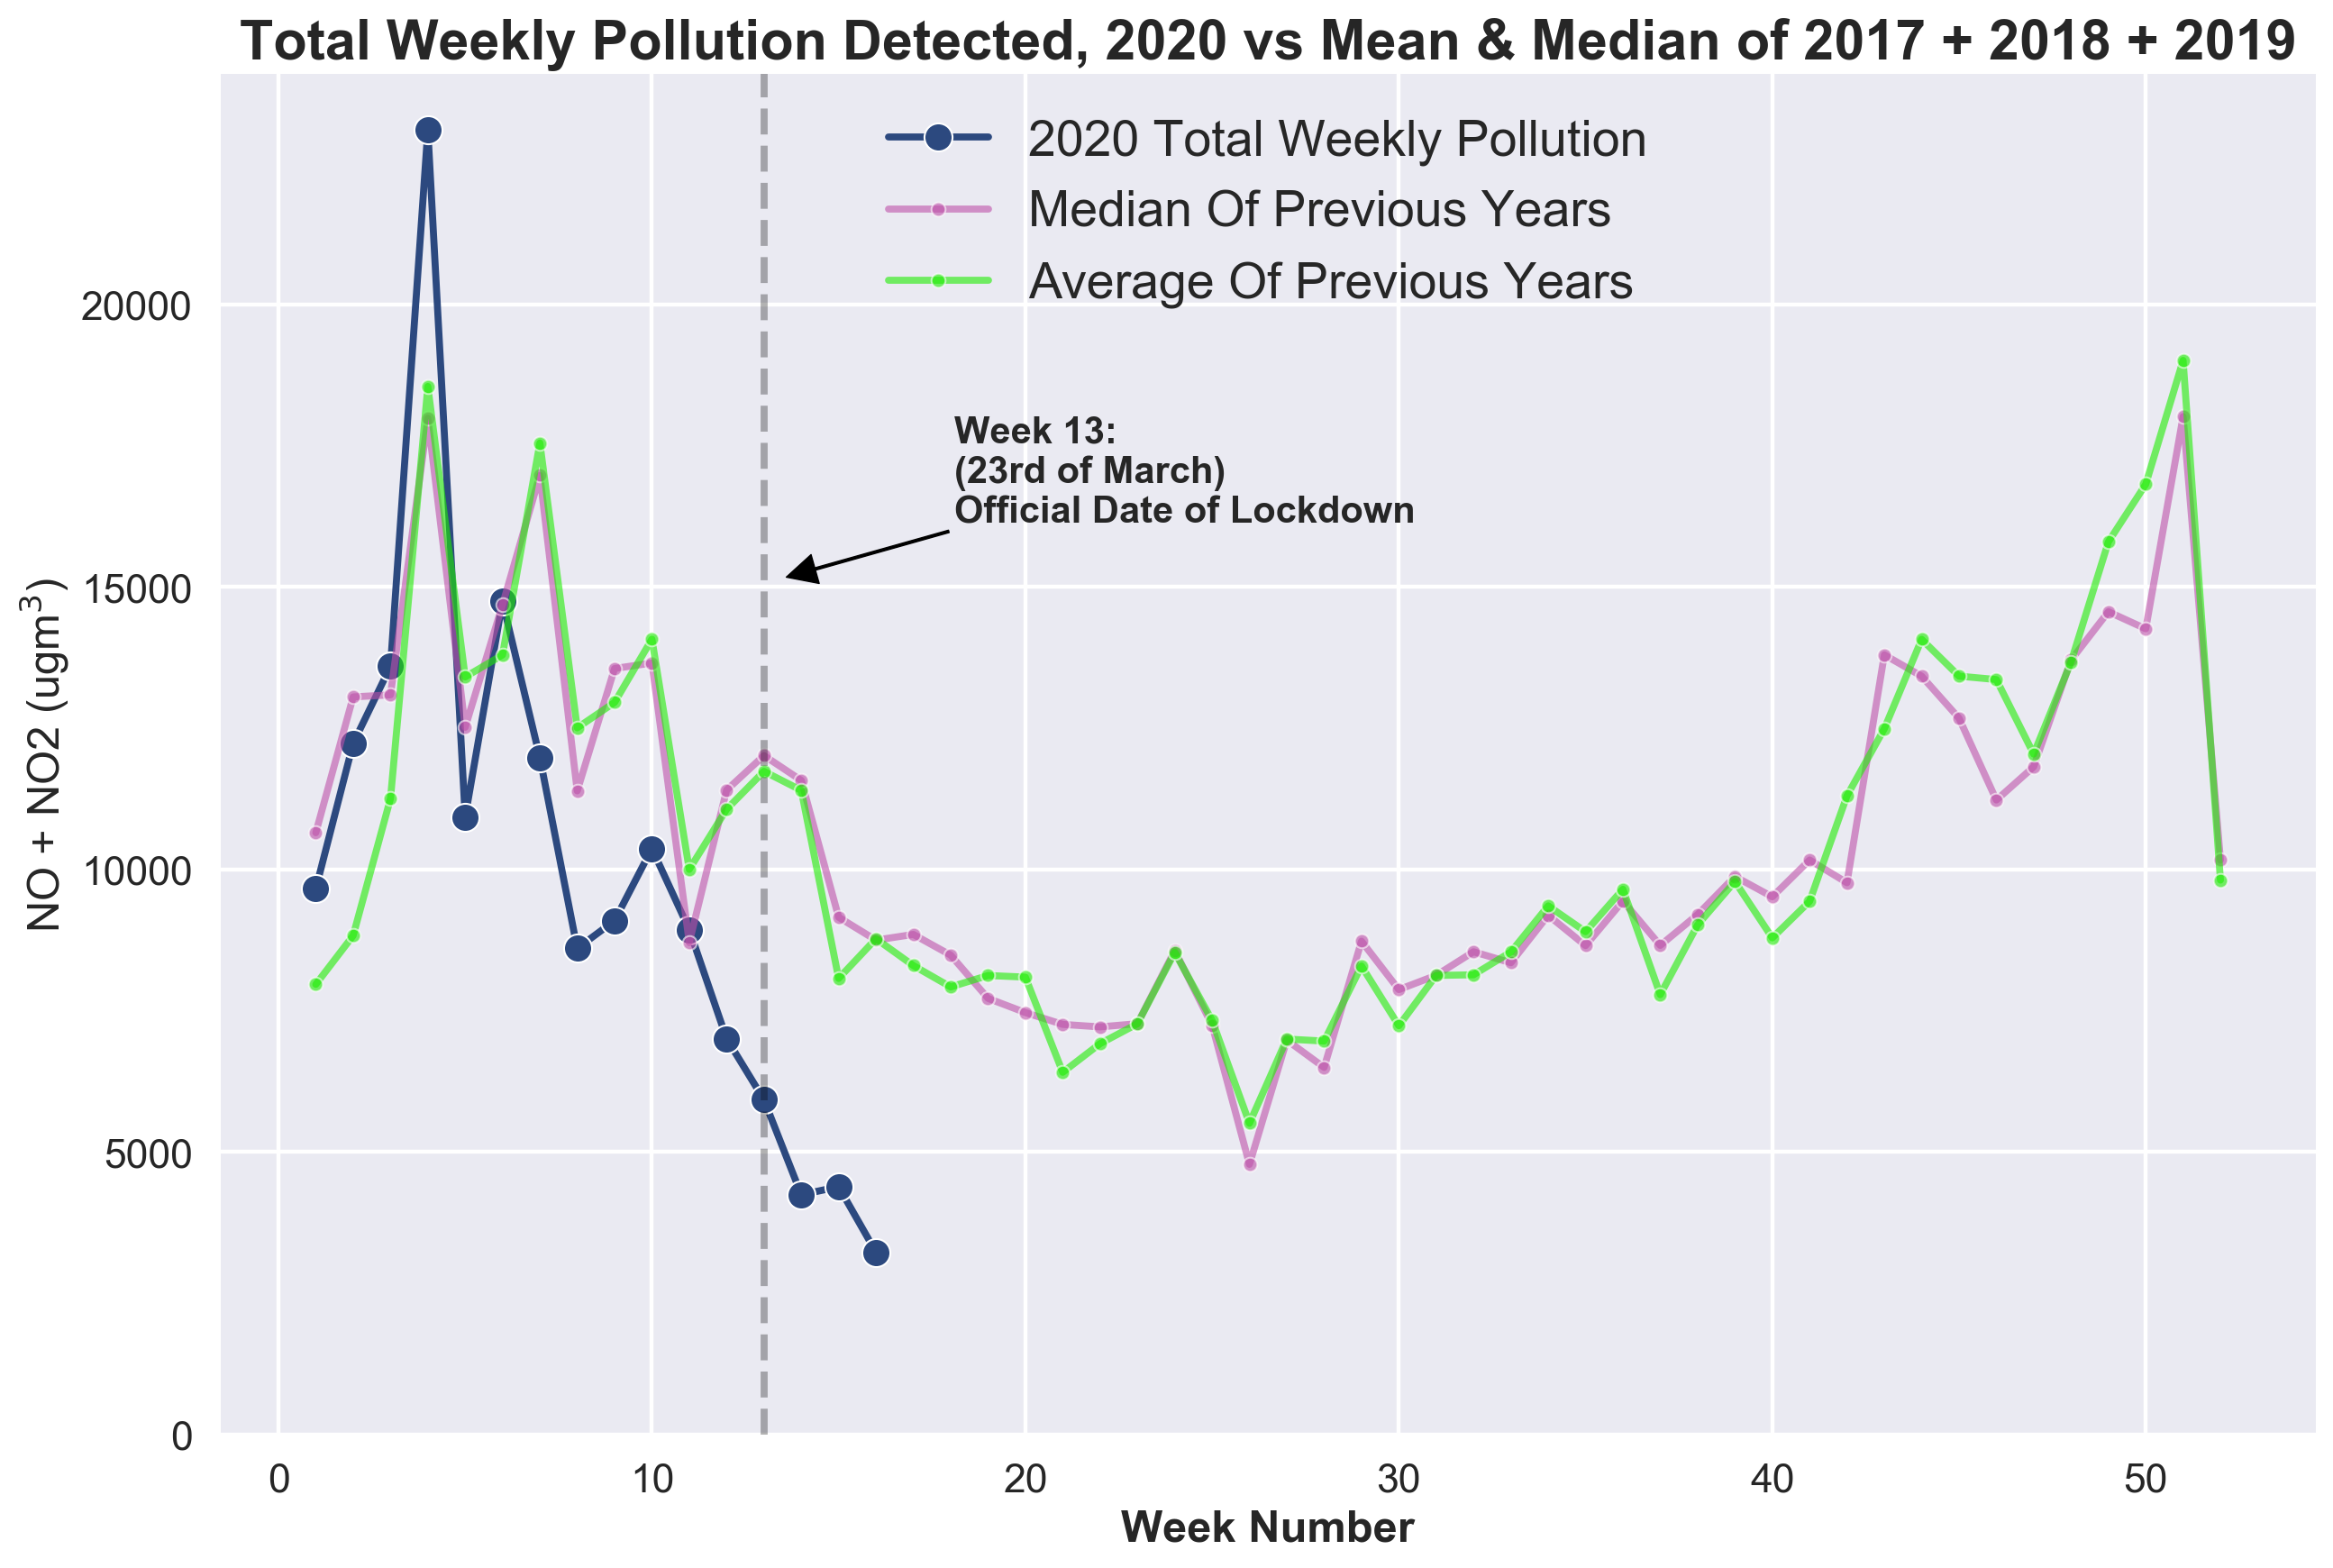

In [29]:
# plotting data
x = plt.figure(figsize=(15,10),dpi=200)
x = sns.lineplot(x=pivoted_clean.index,y=pivoted_clean['2020'],label='2020 Total Weekly Pollution',
             marker='o',alpha=1,color='#2C497F',ci=None)
x = sns.lineplot(x=pivoted_clean.index,y=pivoted_clean['Median Over Previous Years'],
                 label='Median Of Previous Years',alpha=0.6,color='#be51a9',marker='.',ci=None)
x = sns.lineplot(x=pivoted_clean.index,y=pivoted_clean['Mean Over Previous Years'],
                 label='Average Of Previous Years',alpha=0.6,color='#1fed03',marker='.',ci=None)

plt.axvline(13, 0, 1,color='k',alpha=0.3,ls='--')

# Arrow and annotation to explain horizonal line 
plt.annotate(s='Week 13: \n(23rd of March)\nOfficial Date of Lockdown',
                     xy=(0.27,0.63),
                     xytext=(0.35,0.67), 
                     xycoords='axes fraction',
                     textcoords='axes fraction',
                    arrowprops=dict(width=1,fc='k'),
                    fontsize=15,
                    fontweight='bold')

# plot stylings
plt.style.use('seaborn-poster')
plt.legend(loc='upper center',fontsize=20)
plt.ylabel('NO + NO2 (ugm$^3$)')
#plt.ylabel('Nitric oxide + Nitrogen dioxide (ugm$^3$)')
plt.xlabel('Week Number',fontdict={'fontweight':'bold'})
x.set_ylim(0,None)
#plt.xticks(np.arange(21),np.arange(21))
plt.title('Total Weekly Pollution Detected, 2020 vs Mean & Median of 2017 + 2018 + 2019',
         fontdict={'fontweight':'bold','fontsize':22})
#plt.savefig('Derby Images/03b. Weekly 2020 Pollution VS Mean and Median Of Previous Years (Not Zoomed).png')

# would be great to also say % drop compared to median and mean

In [30]:
# Making better named df for instagram
pivoted_clean_limited_ = pivoted_clean_limited.copy()
pivoted_clean_limited_.index = pivoted_clean_limited.index.rename('Week Number')
pivoted_clean_limited_.rename(columns={'Median Over Previous Years':'Median Of 2017, 2018 & 2019',
                                                         '2020':'2020 Weekly Total Pollution',
                              'Mean Over Previous Years':'Average Of 2017, 2018 & 2019',
                               '% Of Median':'2020 as % Of Median Of Previous Years'},inplace=True)
pivoted_clean_limited_.iloc[:16,[1,3,4]]

2020 Weekly Total Pollution  \
Week Number                                
1                             9657.67340   
2                            12228.10082   
3                            13594.20969   
4                            23087.62070   
5                            10926.84212   
6                            14742.12310   
7                            11978.06989   
8                             8601.56153   
9                             9091.92489   
10                           10369.76555   
11                            8933.92665   
12                            7004.79480   
13                            5923.77762   
14                            4241.93698   
15                            4383.93791   
16                            3225.16638   

             2020 as % Of Median Of Previous Years  % Change From Median  
Week Number                                                               
1                                        90.696335             -9.303665  
2                                        93.691517             -6.308483  
3                                       103.864522              3.864522  
4                                       128.379031             28.379031  
5                                        87.317497            -12.682503  
6                                       100.409737              0.409737  
7                                        70.569833            -29.430167  
8                                        75.529752            -24.470248  
9                                        67.077405            -32.922595  
10                                       75.958508            -24.041492  
11                                      102.628388              2.628388  
12                                       61.428684            -38.571316  
13                                       49.306152            -50.693848  
14                                       36.652075            -63.347925  
15                                       47.897609            -52.102391  
16                                       36.868775            -63.131225

Text(0.5, 1.0, '2020 Weekly Pollution As % Of Median Of 2017 + 2018 + 2019')

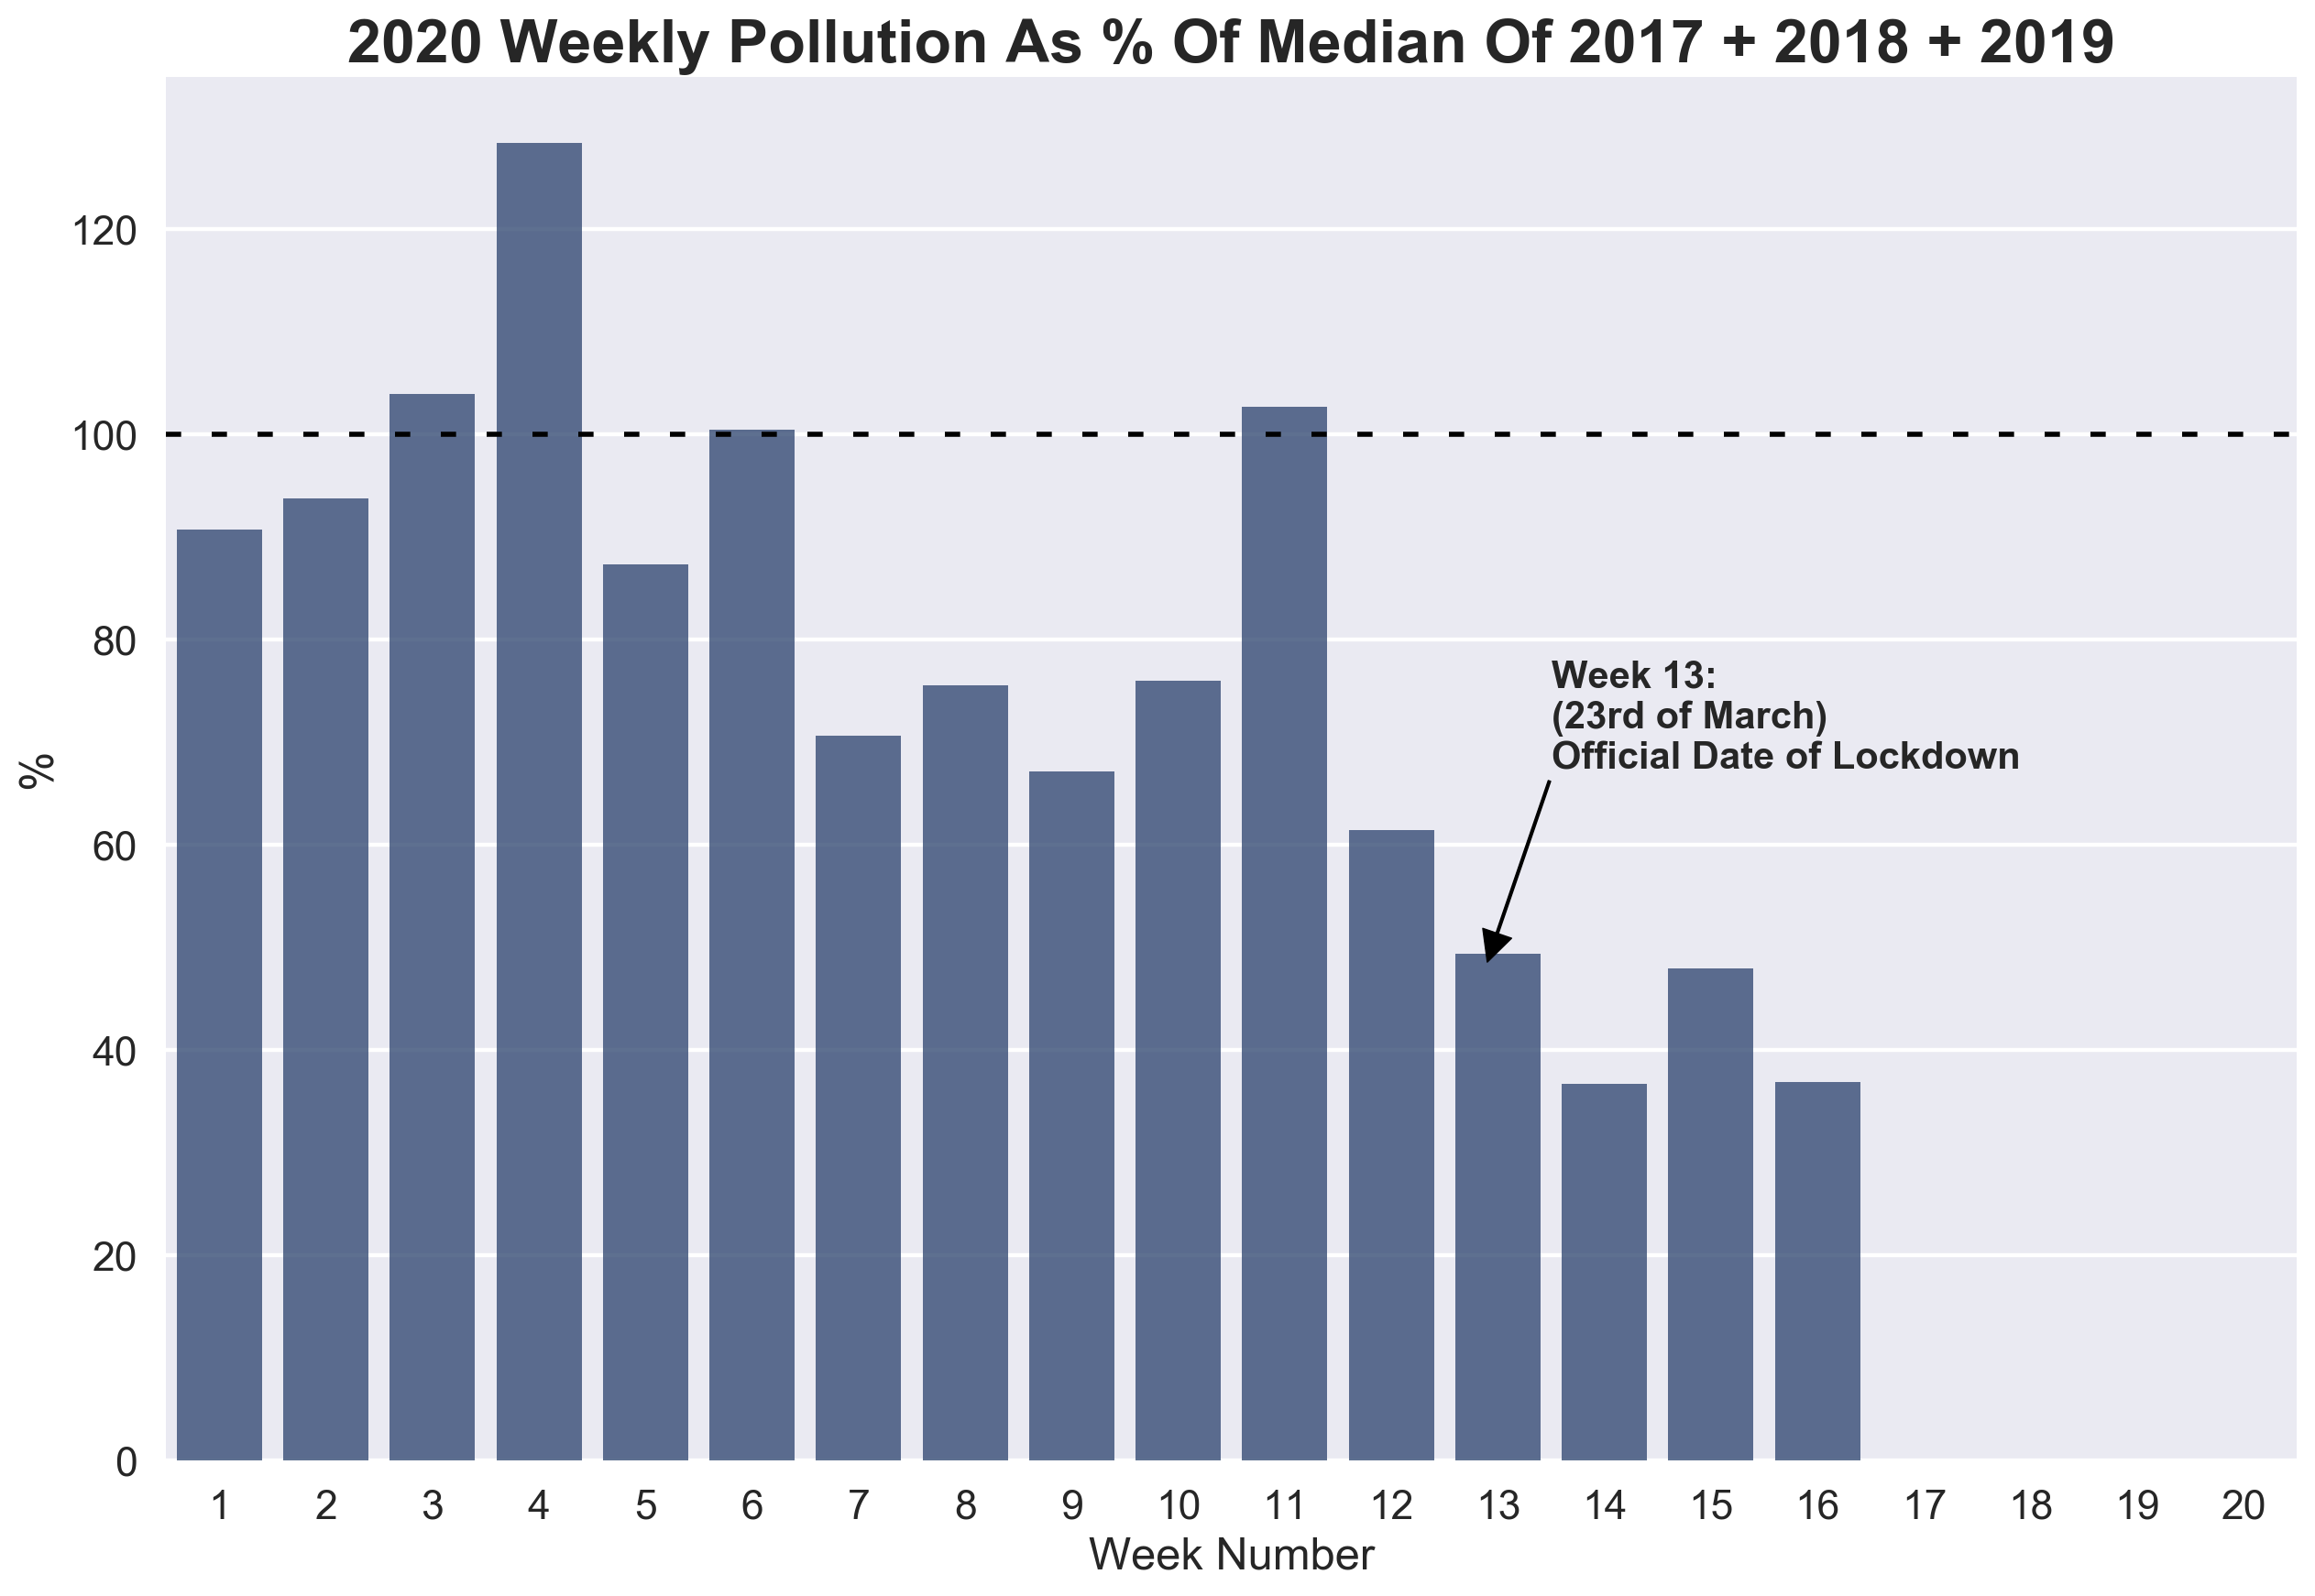

In [31]:
x = plt.figure(figsize=(15,10),dpi=200)

#x = sns.lineplot(x=pivoted_clean_limited.index,y=pivoted_clean_limited['% Of Median'],label='2020 Total Weekly Pollution',
#             marker='o',alpha=1,color='#2C497F',ci=None)

x = sns.barplot(x=pivoted_clean_limited.index,y=pivoted_clean_limited['% Of Median'],label='2020 Total Weekly Pollution',
             alpha=0.8,ci=None,color='#2C497F')

# annotations
plt.axhline(y=100,linewidth=2, color='k',ls=(0,(3,6)))

plt.annotate(s='Week 13: \n(23rd of March)\nOfficial Date of Lockdown',
                     xy=(0.62,0.36),
                     xytext=(0.65,0.5), 
                     xycoords='axes fraction',
                     textcoords='axes fraction',
                    arrowprops=dict(width=1,fc='k'),
                    fontsize=15,
                    fontweight='bold')


# plot stylings
plt.style.use('seaborn-poster')
#plt.legend(loc='upper center')
plt.ylabel('%')
plt.xlabel('Week Number')
x.set_ylim(0,None)
plt.title('2020 Weekly Pollution As % Of Median Of 2017 + 2018 + 2019',fontdict={'fontweight':'bold',                                                                            'fontsize':24})
#plt.savefig('Derby Images/04. 2020 Weekly Total Pollution Vs Median Of Previous Years.png')

# The weeks with lowest pollution on record

Text(0.5, 1.0, '10 Lowest Weeks Of Pollution Since Records Began')

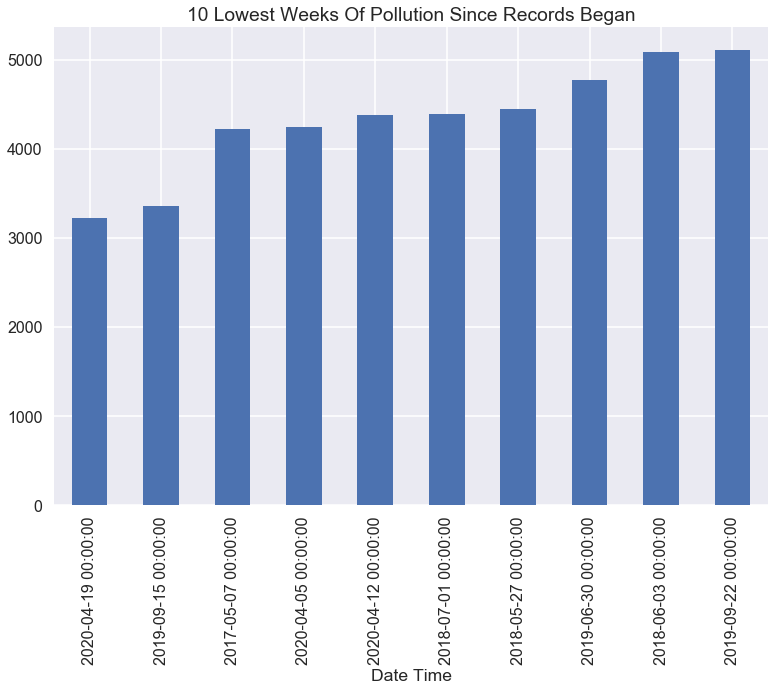

In [32]:
# Skipping first 3 weeks on record as nothing was collected
# Limited to only full weeks
fig = plt.plot()
x = df_all.loc['2017-01-16':'2020-04-19'].resample('W').sum().sort_values(by=['Total'])
x = x.iloc[:10,7]
fig = x.plot.bar()
plt.title('10 Lowest Weeks Of Pollution Since Records Began')

# Monthly Pivot

In [33]:
# Monthly pivot table with specific date range so only full months are measured
df_all_ = df_all.loc['2017-01-01':'2020-03-31'] 
monthly = df_all_.resample('M').sum()
month_piv = monthly.pivot_table('Total', index=[monthly.index.month], columns=monthly.index.year)
month_piv.columns=['2017','2018','2019','2020']

# new columns
month_piv['% of 2019'] = (month_piv['2020']/month_piv['2019'])*100
month_piv['% change'] = ((month_piv['2020']/month_piv['2019'])-1)*100

# median of previous years
z = month_piv.loc[:,['2017','2018','2019']].median(axis=1)
month_piv['Median Of Previous Years'] = z

# median columns 
month_piv['% Of Median'] = (month_piv['2020']/month_piv['Median Of Previous Years'])*100
month_piv['% Change From Median'] = ((month_piv['2020']/month_piv['Median Of Previous Years'])-1)*100

# cleaned up dataframe 
month_piv_clean = month_piv.iloc[:,[6,3,7,8]]
month_piv_clean

Median Of Previous Years         2020  % Of Median  \
Date Time                                                       
1                       63018.95106  63980.42275   101.525687   
2                       51400.74592  45912.19204    89.322035   
3                       50098.27769  34257.20705    68.380010   
4                       42509.04851          NaN          NaN   
5                       32834.78904          NaN          NaN   
6                       32496.47416          NaN          NaN   
7                       32978.27321          NaN          NaN   
8                       38861.70214          NaN          NaN   
9                       44477.42794          NaN          NaN   
10                      51957.30909          NaN          NaN   
11                      53822.11581          NaN          NaN   
12                      66894.90382          NaN          NaN   

           % Change From Median  
Date Time                        
1                      1.525687  
2                    -10.677965  
3                    -31.619990  
4                           NaN  
5                           NaN  
6                           NaN  
7                           NaN  
8                           NaN  
9                           NaN  
10                          NaN  
11                          NaN  
12                          NaN

Text(0.5, 1, 'Total Pollution Measured Per Month Of Each Year')

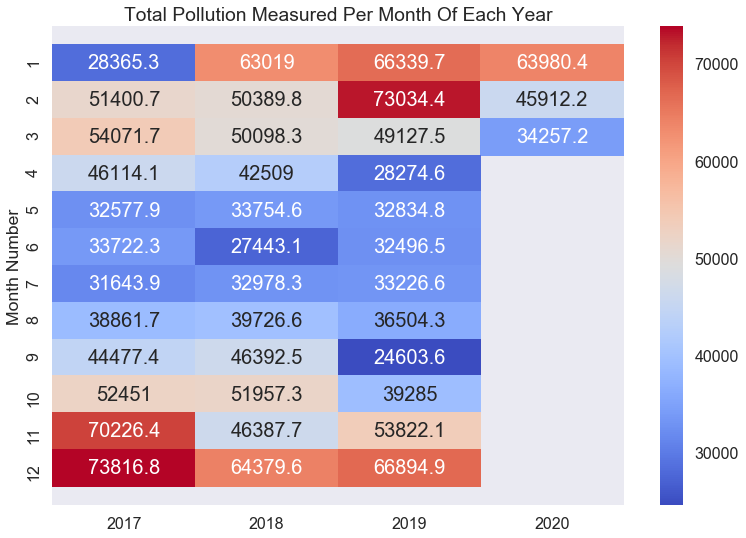

In [34]:
ax = sns.heatmap(month_piv[['2017','2018','2019','2020']],cmap='coolwarm',annot=True,fmt='g',annot_kws={"size": 20})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ylabel('Month Number')
title('Total Pollution Measured Per Month Of Each Year')
#plt.savefig('Derby Images/05. Monthly Pollution of Each Year.png')

Text(0.5, 1, '2020 Monthly Pollution Compared To Median Pollution of Previous 3 Years')

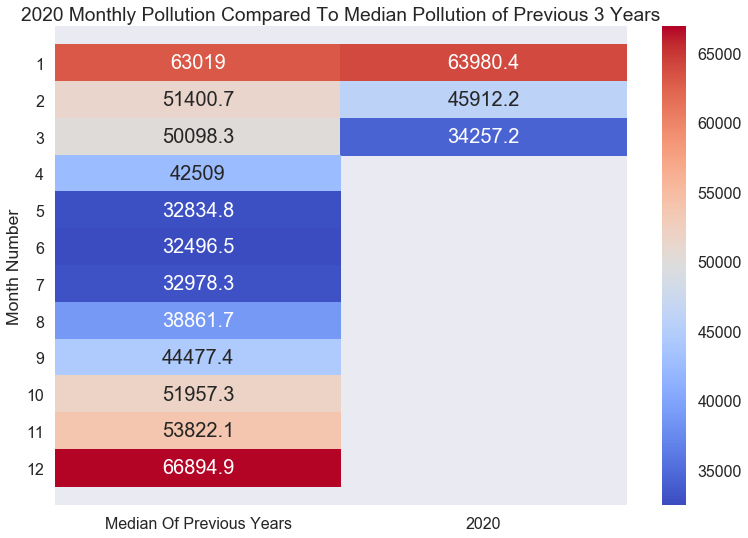

In [35]:
ax = sns.heatmap(month_piv_clean[['Median Of Previous Years','2020']],cmap='coolwarm',annot=True,fmt='g',annot_kws={"size": 20})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ylabel('Month Number')
#yticks(np.arange(12),['Jan','Feb','Mar','Apr','Jun','July','Aug','Sep','Oct','Nov','Dec'])
yticks(rotation=0)
title('2020 Monthly Pollution Compared To Median Pollution of Previous 3 Years')
#plt.savefig('Derby Images/06. Monthly Pollution 2020 vs Median.png')

(0, 70239.64901099997)

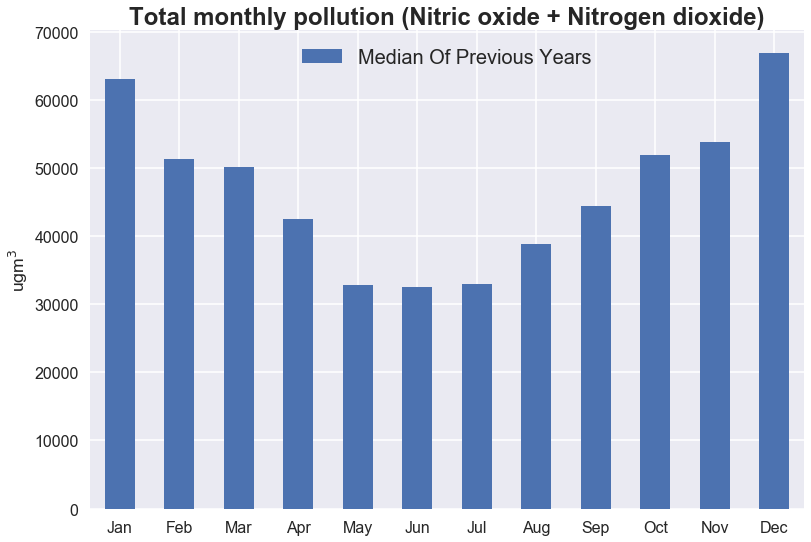

In [36]:
#fig = month_piv_clean[['Median Of Previous Years','2020']].plot.bar()
fig = month_piv_clean['Median Of Previous Years'].plot.bar()
# plot stylings
plt.style.use('seaborn-poster')
plt.legend(loc='upper center',fontsize=20)
plt.ylabel('ugm$^3$')
plt.title('Total monthly pollution (Nitric oxide + Nitrogen dioxide)',fontdict={'fontweight':'bold','fontsize':24})
plt.xlabel('')
plt.xticks(np.arange(12),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],rotation=0)
fig.set_ylim(0,None)

#plt.savefig('Derby Images/08b. Monthly 2020 Pollution VS Median Of Previous Years.png')


# Total Emissions for 1 month of each year


In [37]:
def month_comparison(month_str,years_to_plot):
    '''
    month_str = month in two digit format i.e. March = 03
    years_to_plot = integer. If 4, plot all 4 years, if 3 plot most recent 3 years etc
    '''
    months_with_28_days=['2','02']
    months_with_31_days=['1','01','3','03','5','05','7','07','8','08','10','12']
    months_with_30_days=['4','04','6','06','9','09','11']
    
    if month_str in(months_with_28_days):
        days_in_month = 28
    elif month_str in(months_with_31_days):
        days_in_month = 31
    elif month_str in(months_with_30_days):
        days_in_month=30
        
    # getting month name for title of plot
    monthinteger = int(month_str)
    month = calendar.month_name[monthinteger]
    
    month_17 = df_all.loc['2017-{}-01'.format(month_str):'2017-{}-{}'.format(month_str,days_in_month)] 
    month_18 = df_all.loc['2018-{}-01'.format(month_str):'2018-{}-{}'.format(month_str,days_in_month)]
    month_19 = df_all.loc['2019-{}-01'.format(month_str):'2019-{}-{}'.format(month_str,days_in_month)]
    month_20 = df_all.loc['2020-{}-01'.format(month_str):'2020-{}-{}'.format(month_str,days_in_month)]

    month_17_no = month_17['Nitric oxide'].sum()
    month_17_nd = month_17['Nitrogen dioxide'].sum()

    month_18_no = month_18['Nitric oxide'].sum()
    month_18_nd = month_18['Nitrogen dioxide'].sum()

    month_19_no = month_19['Nitric oxide'].sum()
    month_19_nd = month_19['Nitrogen dioxide'].sum()

    month_20_no = month_20['Nitric oxide'].sum()
    month_20_nd = month_20['Nitrogen dioxide'].sum()

    # Making a new dataframe to plot
    data = {'{}-2017'.format(month_str):[month_17_no,month_17_nd],
           '{}-2018'.format(month_str):[month_18_no, month_18_nd],
            '{}-2019'.format(month_str):[month_19_no, month_19_nd],
            '{}-2020'.format(month_str):[month_20_no, month_20_nd]}

    df = pd.DataFrame(data)
    df.index = ['Nitric Oxide','Nitrogen Dioxide']
    
    
    if years_to_plot==4:
        df_=df
    elif years_to_plot==3:
        df_=df[['{}-2018'.format(month_str),'{}-2019'.format(month_str),'{}-2020'.format(month_str)]]
    elif years_to_plot==2:
        df_=df[['{}-2019'.format(month_str),'{}-2020'.format(month_str)]]
    elif years_to_plot==1:
        df_=df[['{}-2020'.format(month_str)]]
    
    # plot stylings
    plt.style.use('seaborn-poster')
    df_.plot.bar(figsize=[15,10])
    plt.title('Total Emissions In {} of Each Year'.format(month))
    plt.ylabel('Total Emissions Measured (ugm$^3$)')
    plt.xticks(rotation=0)
    plt.legend(loc='upper center')
    ax = plt.gca() # not entirely sure what this does but it lets me make an ax after the fact for editing!
    ax.set_facecolor('#eaeaf2')
    plt.grid(True,color='w')
    x.set_ylim(0,None)

In [38]:
#month_comparison(month_str='4',years_to_plot=4)

# add specifying the years to analyse too 

# Looking at different features like weekday, weather etc
- Currently have week, day of week, quarter, weekday or weekend

In [39]:
df_all

Nitric oxide  Nitrogen dioxide  \
Date Time                                             
2017-01-01 01:00:00           NaN               NaN   
2017-01-01 02:00:00           NaN               NaN   
2017-01-01 03:00:00           NaN               NaN   
2017-01-01 04:00:00           NaN               NaN   
2017-01-01 05:00:00           NaN               NaN   
...                           ...               ...   
2020-04-21 20:00:00       1.37203          11.28375   
2020-04-21 21:00:00       0.99784           8.98875   
2020-04-21 22:00:00       0.62365           7.45875   
2020-04-21 23:00:00       0.74838           7.84125   
2020-04-22 00:00:00       0.62365           7.84125   

                     Nitrogen oxides as nitrogen dioxide           Date Time  \
Date Time                                                                      
2017-01-01 01:00:00                                  NaN 2017-01-01 01:00:00   
2017-01-01 02:00:00                                  NaN 2017-01-01 02:00:00   
2017-01-01 03:00:00                                  NaN 2017-01-01 03:00:00   
2017-01-01 04:00:00                                  NaN 2017-01-01 04:00:00   
2017-01-01 05:00:00                                  NaN 2017-01-01 05:00:00   
...                                                  ...                 ...   
2020-04-21 20:00:00                             13.38750 2020-04-21 20:00:00   
2020-04-21 21:00:00                             10.51875 2020-04-21 21:00:00   
2020-04-21 22:00:00                              8.41500 2020-04-21 22:00:00   
2020-04-21 23:00:00                              8.98875 2020-04-21 23:00:00   
2020-04-22 00:00:00                              8.79750 2020-04-22 00:00:00   

                     Week  Day Of Week  Quarter  Month Weekday Or Weekend  \
Date Time                                                                   
2017-01-01 01:00:00    52            6        1      1            Weekend   
2017-01-01 02:00:00    52            6        1      1            Weekend   
2017-01-01 03:00:00    52            6        1      1            Weekend   
2017-01-01 04:00:00    52            6        1      1            Weekend   
2017-01-01 05:00:00    52            6        1      1            Weekend   
...                   ...          ...      ...    ...                ...   
2020-04-21 20:00:00    17            1        2      4            Weekday   
2020-04-21 21:00:00    17            1        2      4            Weekday   
2020-04-21 22:00:00    17            1        2      4            Weekday   
2020-04-21 23:00:00    17            1        2      4            Weekday   
2020-04-22 00:00:00    17            2        2      4            Weekday   

                        Total  
Date Time                      
2017-01-01 01:00:00       NaN  
2017-01-01 02:00:00       NaN  
2017-01-01 03:00:00       NaN  
2017-01-01 04:00:00       NaN  
2017-01-01 05:00:00       NaN  
...                       ...  
2020-04-21 20:00:00  12.65578  
2020-04-21 21:00:00   9.98659  
2020-04-21 22:00:00   8.08240  
2020-04-21 23:00:00   8.58963  
2020-04-22 00:00:00   8.46490  

[28968 rows x 10 columns]

In [40]:
df_all.resample('D').sum()

Nitric oxide  Nitrogen dioxide  \
Date Time                                    
2017-01-01       0.00000           0.00000   
2017-01-02       0.00000           0.00000   
2017-01-03       0.00000           0.00000   
2017-01-04       0.00000           0.00000   
2017-01-05       0.00000           0.00000   
...                  ...               ...   
2020-04-18      44.77807         306.38250   
2020-04-19      29.06209         227.97000   
2020-04-20      53.38444         260.86500   
2020-04-21      51.38876         283.24125   
2020-04-22       0.62365           7.84125   

            Nitrogen oxides as nitrogen dioxide  Week  Day Of Week  Quarter  \
Date Time                                                                     
2017-01-01                              0.00000  1196          138       23   
2017-01-02                              0.00000    24            0       24   
2017-01-03                              0.00000    24           24       24   
2017-01-04                              0.00000    24           48       24   
2017-01-05                              0.00000    24           72       24   
...                                         ...   ...          ...      ...   
2020-04-18                            375.04125   384          120       48   
2020-04-19                            272.53125   384          144       48   
2020-04-20                            342.72000   408            0       48   
2020-04-21                            362.03625   408           24       48   
2020-04-22                              8.79750    17            2        2   

            Month      Total  
Date Time                     
2017-01-01     23    0.00000  
2017-01-02     24    0.00000  
2017-01-03     24    0.00000  
2017-01-04     24    0.00000  
2017-01-05     24    0.00000  
...           ...        ...  
2020-04-18     96  351.16057  
2020-04-19     96  257.03209  
2020-04-20     96  314.24944  
2020-04-21     96  334.63001  
2020-04-22      4    8.46490  

[1208 rows x 8 columns]

Text(0, 0.5, 'NO + NO2 (ugm$^3$)')

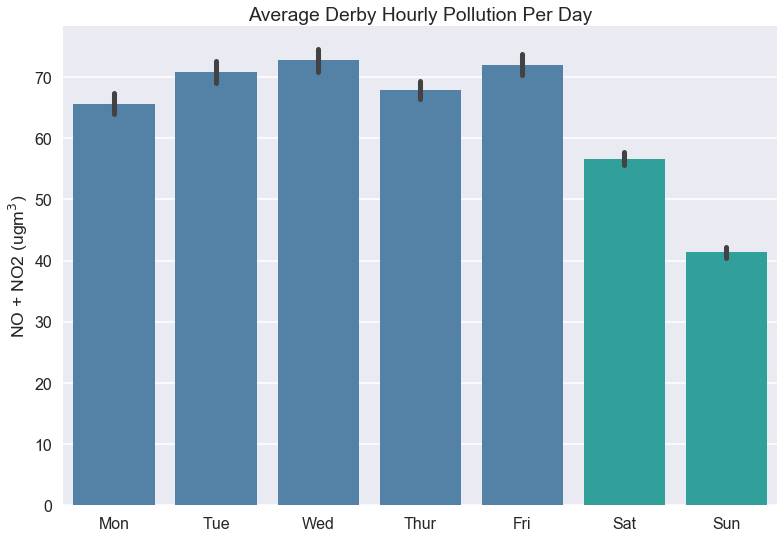

In [41]:
#sns.barplot(x='Day Of Week',y='Total',data=df_all,hue = 'Weekday Or Weekend')

sns.barplot(x='Day Of Week',y='Total',data=df_all,palette=['steelblue','steelblue','steelblue','steelblue',
                                                          'steelblue','lightseagreen','lightseagreen'])
plt.xticks(np.arange(7),['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
plt.ylabel('Average Total Pollution')
## What are the units for this? Also I don't even know if it is doing an average
plt.xlabel('')
plt.title('Average Derby Hourly Pollution Per Day')
plt.ylabel('NO + NO2 (ugm$^3$)')


Text(0, 0.5, 'NO + NO2 (ugm$^3$)')

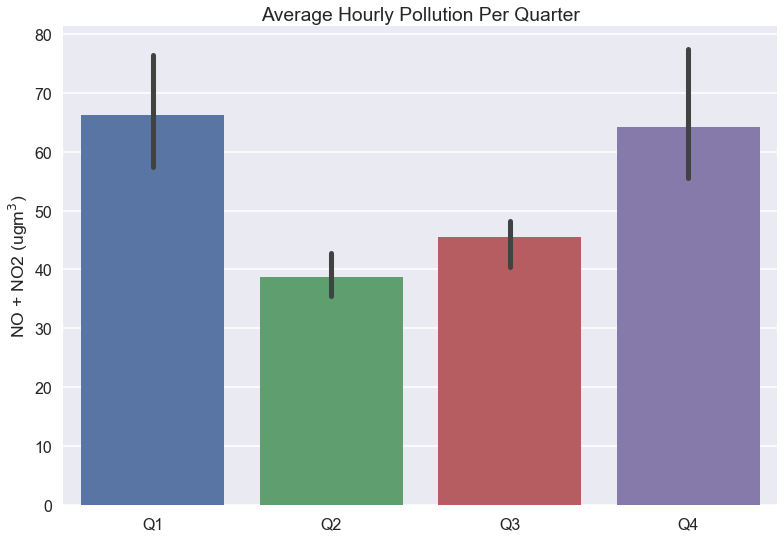

In [42]:
quart = df_all.loc['2017-01-01':'2019-12-31'].resample('Q').median()
quart = quart[['Total','Quarter']]
sns.barplot(x=quart.Quarter,y=quart.Total)

plt.xticks(np.arange(4),['Q1','Q2','Q3','Q4'])
plt.xlabel('')
plt.title('Average Hourly Pollution Per Quarter')
plt.ylabel('NO + NO2 (ugm$^3$)')


# Plotting months of all years next to each other 

([<matplotlib.axis.XTick at 0x1a1f5b3b90>,
 <a list of 12 Text xticklabel objects>)

<Figure size 18000x18000 with 0 Axes>

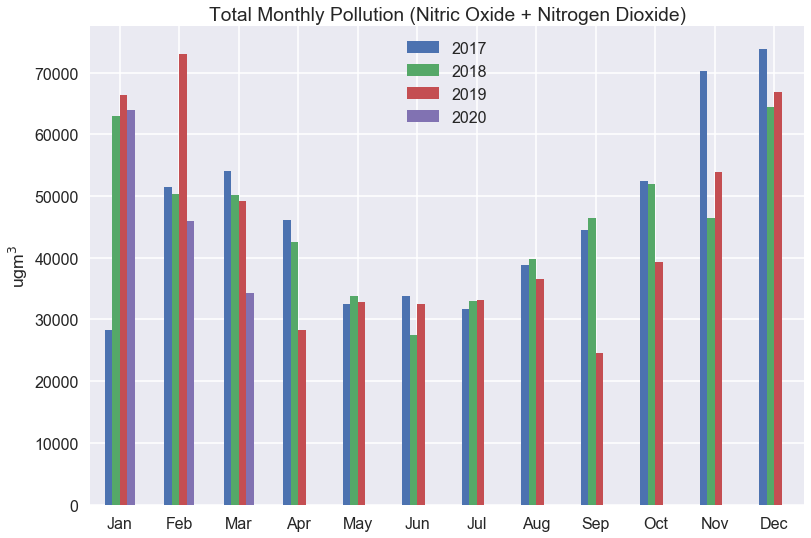

In [43]:
x = df_all.loc['2017-01-01':'2020-03-31'] # so it's only full months
# First, make pivot table
monthly = x.resample('M').sum()
pivoted = monthly.pivot_table('Total', index=[monthly.index.month], columns=monthly.index.year)
pivoted.columns=['2017','2018','2019','2020']

# plotting data
plt.style.use('seaborn')
plt.style.use('seaborn-poster')
plt.figure(figsize=(15,15),dpi=1200)
pivoted.plot(kind='bar')

# plot stylings
plt.title('Total Monthly Pollution (Nitric Oxide + Nitrogen Dioxide)')
plt.legend(loc='upper center')
plt.ylabel('ugm$^3$')
plt.xlabel('')
plt.xticks(rotation=0)
plt.xticks(np.arange(12),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
#plt.savefig('Derby images/09. Monthly Pollution.png')

# VS Apple Mobility Data

### data cleaning

In [44]:
#df_apple[df_apple['region']=='UK']
df_apple_uk = df_apple.iloc[139:142,:].copy()
df_apple_uk.drop(columns=['geo_type','region'],inplace=True)
df_apple_uk = df_apple_uk.transpose()
new_header = df_apple_uk.iloc[0] #grab the first row for the header
df_apple_uk = df_apple_uk[1:] #take the data less the header row
df_apple_uk.columns = new_header #set the header row as the df header

# want to make index into a time series index
df_apple_uk.index = pd.to_datetime(df_apple_uk.index)

# turning numbers in 'driving','transit' and 'walking' columns to floats
df_apple_uk['driving'] = df_apple_uk['driving'].astype(float)
df_apple_uk['transit'] = df_apple_uk['transit'].astype(float)
df_apple_uk['walking'] = df_apple_uk['walking'].astype(float)

Text(0.5, 1.0, 'UK Apple Mobility Data (released to help with coronavirus tracking)')

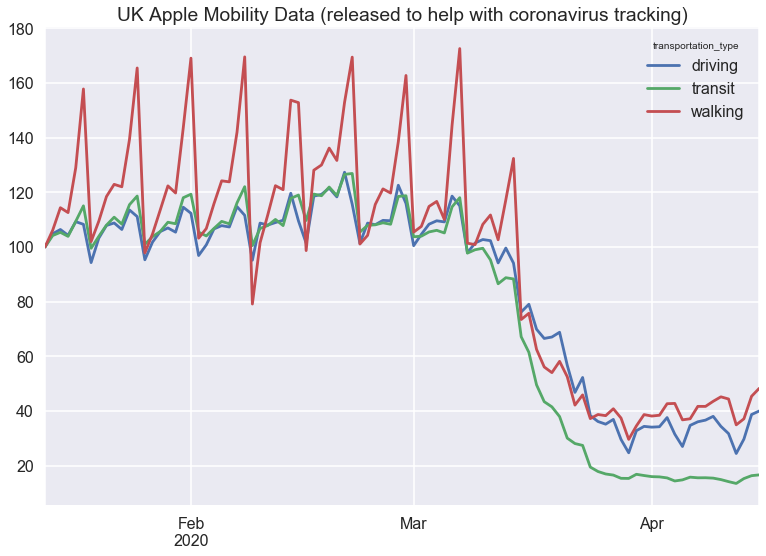

In [45]:
df_apple_uk.plot()
plt.title('UK Apple Mobility Data (released to help with coronavirus tracking)')

In [46]:
### the apple data and derby data need to be same size

## apple data starts when?
df_apple_uk # 13th of Jan
## apple data starts when?
df_apple_uk.tail() # 15th of April

df_2020_apple = df_2020.loc['2020-01-13':'2020-04-15'].copy()

In [47]:
df_2019_apple = df_2019.loc['2019-01-13':'2019-04-16'].copy()
df_2018_apple = df_2018.loc['2018-01-13':'2018-04-16'].copy()

ConversionError: Failed to convert value(s) to axis units: '2020-03-23'

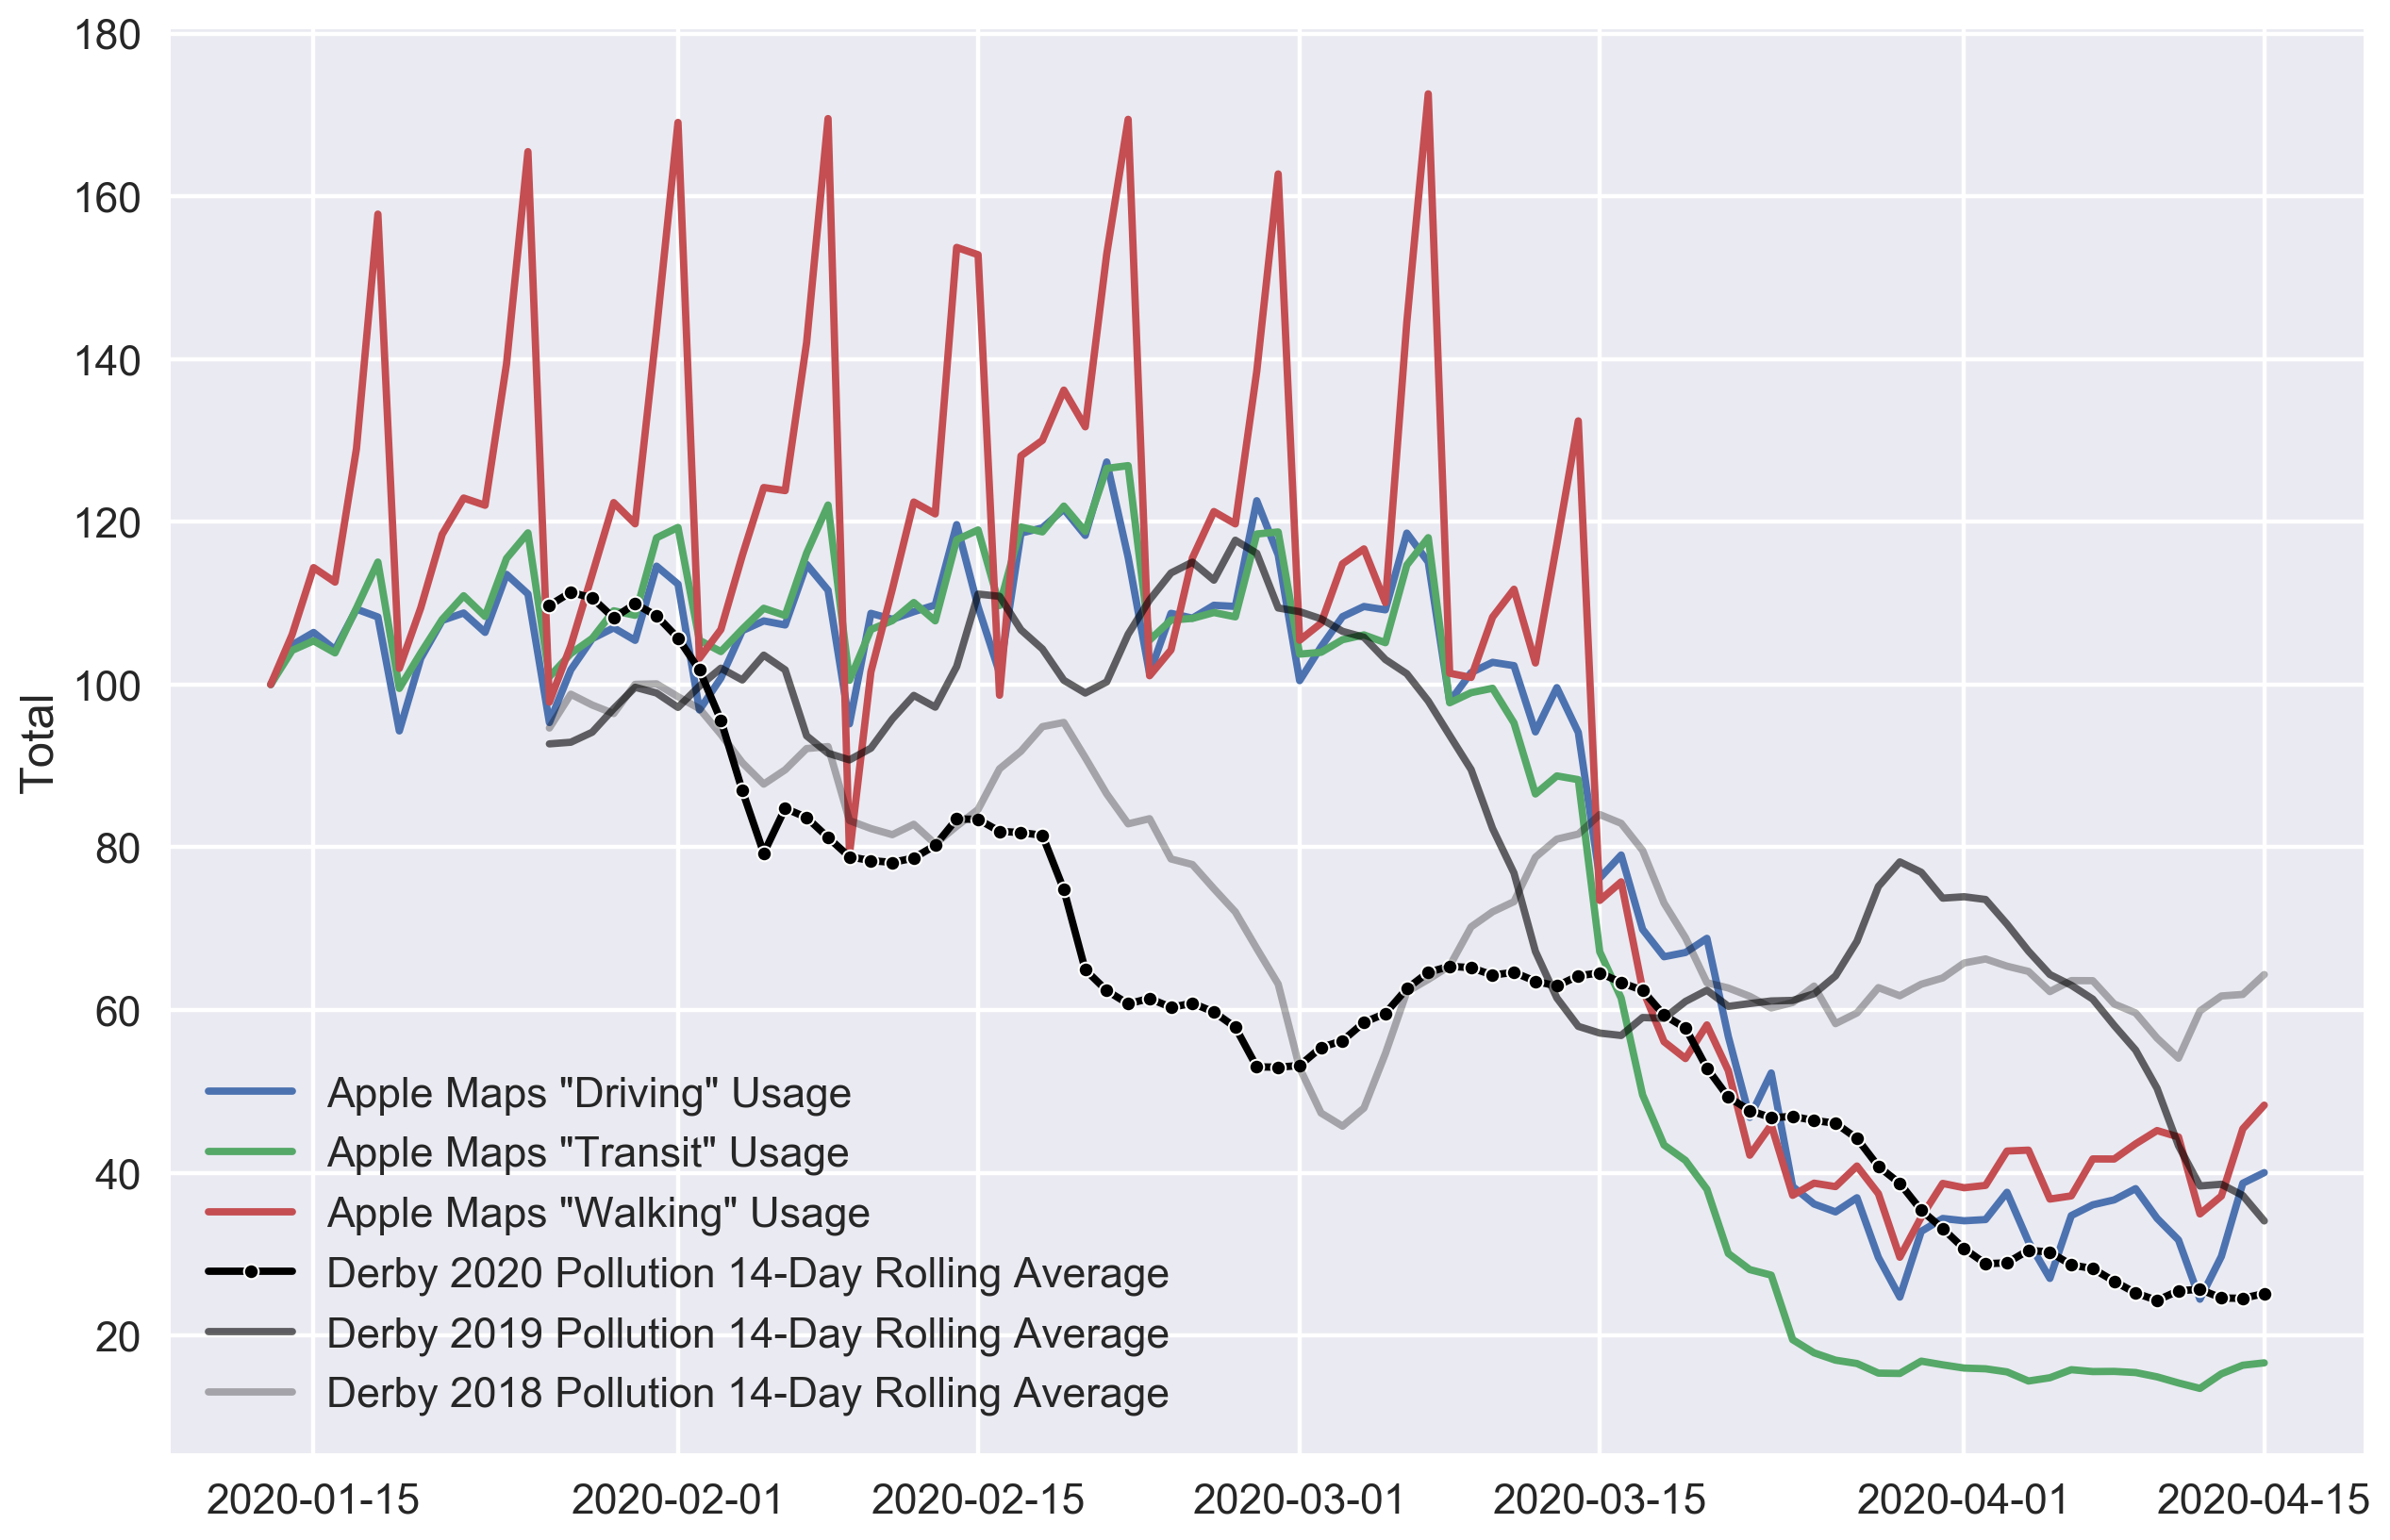

In [48]:
x = plt.figure(figsize=(15,10),dpi=200)

# Plotting data on top of each other
# Apple driving
x = sns.lineplot(x=df_apple_uk.index,y=df_apple_uk['driving'],label='Apple Maps "Driving" Usage',alpha=1) #,color='#2C497F'

# Apple transit 
x = sns.lineplot(x=df_apple_uk.index,y=df_apple_uk['transit'],
                 label='Apple Maps "Transit" Usage',alpha=1) #,color='#775253'

# Apple walking 
x = sns.lineplot(x=df_apple_uk.index,y=df_apple_uk['walking'],
                 label='Apple Maps "Walking" Usage',alpha=1) # ,color='#FF9914'

# Derby 2020 rolling average
x = sns.lineplot(x=df_apple_uk.index,y=df_2020_apple['Total'].resample('D').mean().rolling(14).mean(),
                 label='Derby 2020 Pollution 14-Day Rolling Average',alpha=1,ci=None,color='k',marker='.') # ,color='r'

# Derby 2019 rolling average
x = sns.lineplot(x=df_apple_uk.index,y=df_2019_apple['Total'].resample('D').mean().rolling(14).mean(),
                 label='Derby 2019 Pollution 14-Day Rolling Average',alpha=0.6,ci=None,color='k',ls='--') # ,color='r'

# Derby 2018 rolling average
x = sns.lineplot(x=df_apple_uk.index,y=df_2018_apple['Total'].resample('D').mean().rolling(14).mean(),
                 label='Derby 2018 Pollution 14-Day Rolling Average',alpha=0.3,ci=None,color='k',ls='--') # ,color='r'

# Horizontal line to demark date of lockdown
plt.axvline('2020-03-23', 0, 0.77,color='k',alpha=0.5,ls='--')

# Arrow and annotation to explain horizonal line 
plt.annotate(s='23rd of March: \nOfficial Date Of \nLockdown',
                     xy=(0.73,0.5),
                     xytext=(0.8,0.6), 
                     xycoords='axes fraction',
                     textcoords='axes fraction',
                    arrowprops=dict(width=1,fc='k'),
                    fontsize=15,
                    fontweight='bold')

# plot stylings
plt.style.use('seaborn-poster')
plt.legend(loc='bottom right') #,bbox_to_anchor=(1,0.5))
plt.ylabel('')
plt.xlabel('')
plt.title('UK Apple Mobility Data Vs Derby 2020 Pollution')
#plt.savefig('Derby Images/09. Apple Mobility VS Derby Air Pollution.png')

## Above Apple vs Derby plot but with differencing applied to Derby 

In [ ]:
from statsmodels.tsa.statespace.tools import diff

In [ ]:
df_2020_apple['Diff'] = diff(series=df_2020_apple['Total'],k_diff=1,seasonal_periods=1)

In [ ]:
df_2020_apple['Diff'].plot() #hmmm